#### Sertac İnce

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision

import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda')

# Cool plotting :d
plt.style.use('dark_background')

---

# Regression Part

---

### Defining the Regression Net

In [ ]:
class Reg_Net1(nn.Module):
   def __init__(self):
       super(Reg_Net1, self).__init__()
       self.relu = nn.ReLU()
       self.layer1 = torch.nn.Linear(1, 8)
       self.layer2 = torch.nn.Linear(8, 1)


   def forward(self, x):
       x = self.layer1(x)      
       x = self.relu(x)
       x = self.layer2(x)
       
       return x
   
class Reg_Net2(nn.Module):
   def __init__(self):
       super(Reg_Net2, self).__init__()
       self.relu = nn.ReLU()
       self.layer1 = torch.nn.Linear(1, 64)
       self.layer2 = torch.nn.Linear(64, 32)
       self.layer3 = torch.nn.Linear(32, 16)
       self.layer4 = torch.nn.Linear(16, 8)
       self.layer5 = torch.nn.Linear(8, 1)


   def forward(self, x):
       x = self.layer1(x)      
       x = self.relu(x)
       x = self.layer2(x)
       x = self.relu(x)
       x = self.layer3(x)
       x = self.relu(x)
       x = self.layer4(x)
       x = self.relu(x)
       x = self.layer5(x)
       
       return x   

### Creating and visualizing Random Data for Regression

For data creation, I used the function that was used in Midterm part2. I used the equation that is activation function's derivative with respect to Z (for this function it is x).
And I add sin wave for getting more non-polynomial data. 

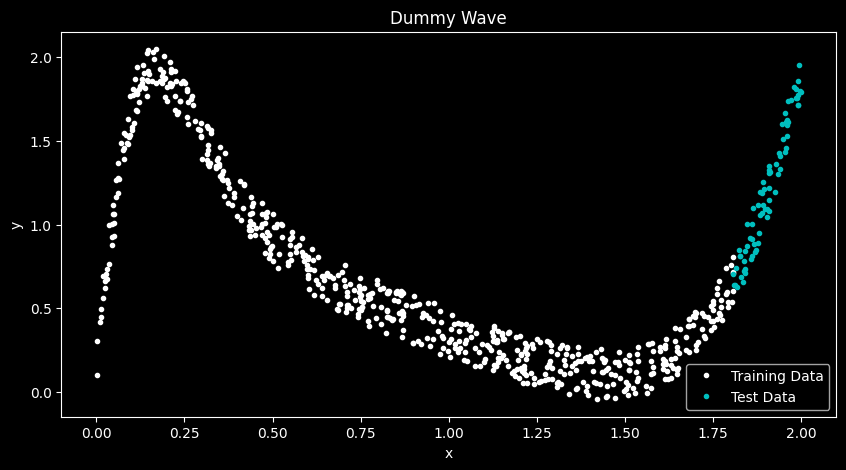

In [ ]:
# Visualize our data
a = 4
b = 10
x = np.random.uniform(low=0, high=2, size=(700,))
x = np.sort(x)
# x = np.random.rand(200)
y = ((x**4) * (a**2) + 3*(x**2) * (a**2)  - b*(x**b) + b)  / (((x**2) * (a**2) + 1) ** 2) * np.sin(x*2) + np.random.uniform(low=0, high=2, size=(700,)) * 0.15

x_train, y_train = x[:625], y[:625]
x_test, y_test = x[625:], y[625:]

# x = np.append(x, [0.3, 0.9, 0.7])
# y = np.append(y, [5.5, 2.0, 6.0])
# plt.scatter(x, y, c="black")
# plt.show()

# Plot the data
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, "w.",  label="Training Data")
plt.plot(x_test, y_test, "c.", label="Test Data")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dummy Wave")
plt.legend()
plt.show()

x_train, y_train = torch.tensor(x_train).float().unsqueeze(1), torch.tensor(y_train).float().unsqueeze(1)
x_test, y_test = torch.tensor(x_test).float().unsqueeze(1), torch.tensor(y_test).float().unsqueeze(1)

In [ ]:
# convert numpy array to tensor in shape of input size
# x = torch.from_numpy(x_train.reshape(-1,1)).float()
# y = torch.from_numpy(y_train.reshape(-1,1)).float()


### Train Function

In [ ]:
def train_regression(epoch, train, test, opt_name, optimizer, model, results, loss_func):
    for i in range(epoch+1):
        train_loss = 0.0
        model.train()

        # Training part
        for data, targets in train:
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_func(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        if i % 500 == 0:
            # plot and show learning process
            plt.cla()
            plt.plot(x_train.numpy(), y_train.numpy(), "w.", label="Train Data")
            plt.title("Train Data")

            plt.plot(data.numpy(), outputs.data.numpy(), 'm^', lw=2, label="Train Predict Data")
            plt.text(2.1, 0.75, f'Optimizer: {opt_name}\n\nEpoch = {i}\n\nLoss = {loss.data.numpy():.4f}' , fontdict={'size': 13, 'color':  'magenta', 'fontname':'Comic Sans MS'})
            plt.legend()
            plt.pause(0.1)
    

        # Validate the network
        test_loss = 0.0
        model.eval()
        with torch.no_grad():
            for data, targets in test:
                outputs = model(data)
                loss = loss_func(outputs, targets)
                test_loss += loss.item() * data.size(0)


            if i % 500 == 0:
                # plot and show learning process
                plt.cla()
                plt.plot(x_test.numpy(), y_test.numpy(), "c.", label="Test Data")
                plt.title("Test Data")
                plt.plot(data.numpy(), outputs.data.numpy(), 'm^', lw=2, label="Test Predict Data")
                plt.text(2.03, 0.8, f'Optimizer: {opt_name}\n\nEpoch = {i}\n\nLoss = {loss.data.numpy():.4f}' , fontdict={'size': 13, 'color':  'magenta', 'fontname':'Comic Sans MS'})
                plt.legend()
                plt.pause(0.1)    

        
        # Record the results
        train_loss /= len(train.dataset)
        test_loss /= len(test.dataset)
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss) 

      
          
    plt.show()
    return results

### Setting Data Loader and Hyperparameters

In [ ]:
# inputs = Variable(x)
# outputs = Variable(y)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=256, shuffle=True)

learning_rate = 0.01
epoch = 2000
regnet1 = Reg_Net1()
regnet2 = Reg_Net2()
models = [regnet1, regnet2]

loss_func = torch.nn.MSELoss()

optimizers = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam,
    "RMSprop": torch.optim.RMSprop,
    "Adadelta": torch.optim.Adadelta
}

## Iterating Over the Optimizers and Models and Visualizing Their Performance

I am visualizing the learning process (curve fitting) for every 500 epoch. And also I am visualizing loss values after every optimizer changes.

------------------------ Optimizer SGD training.. ------------------------

########################## TRAINING ON Reg_Net1 ##########################


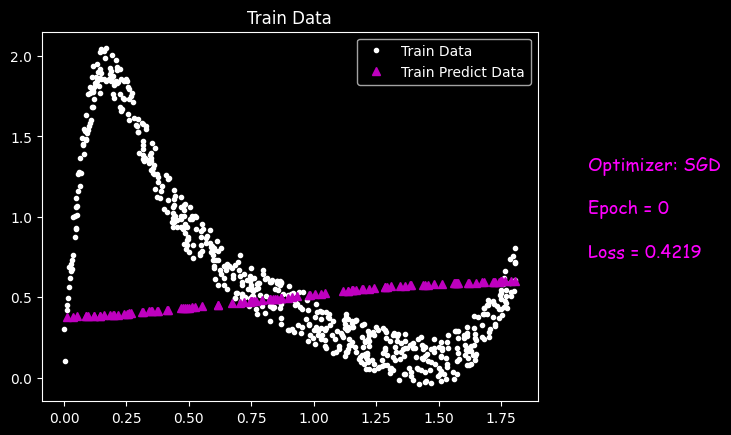

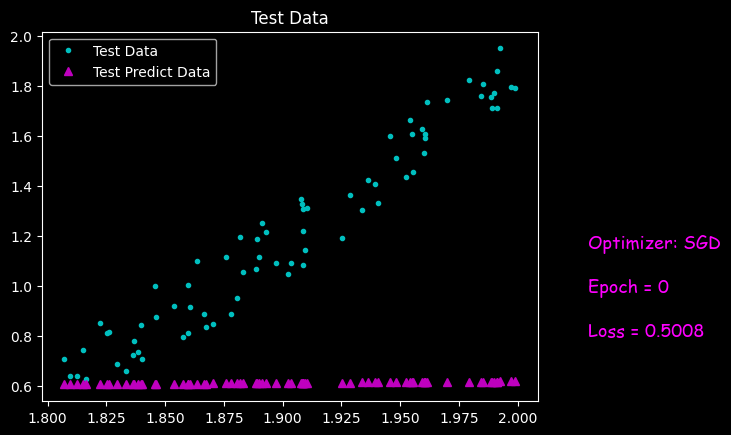

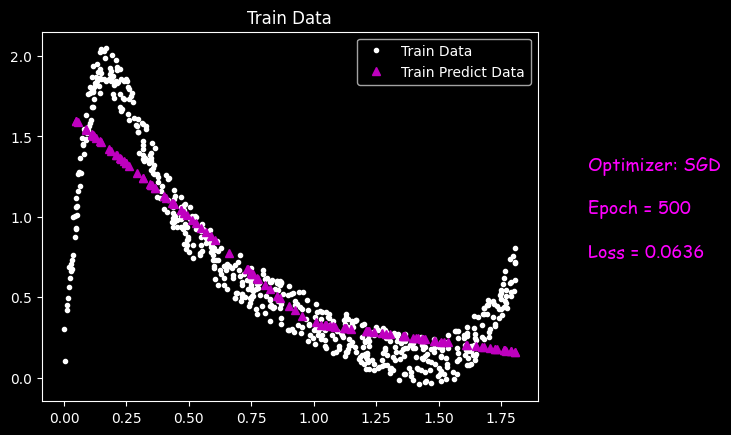

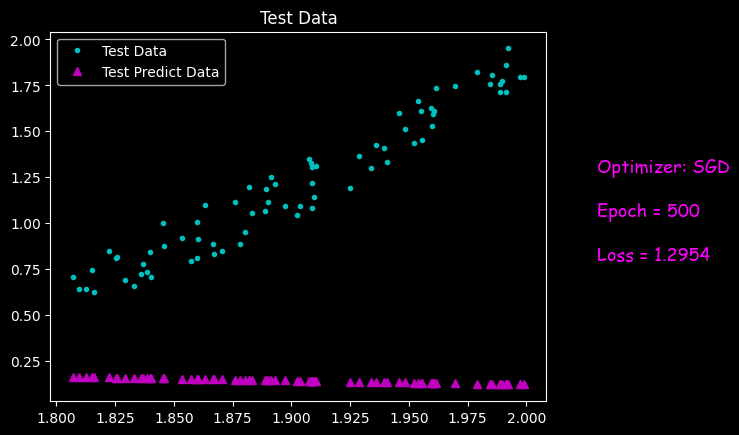

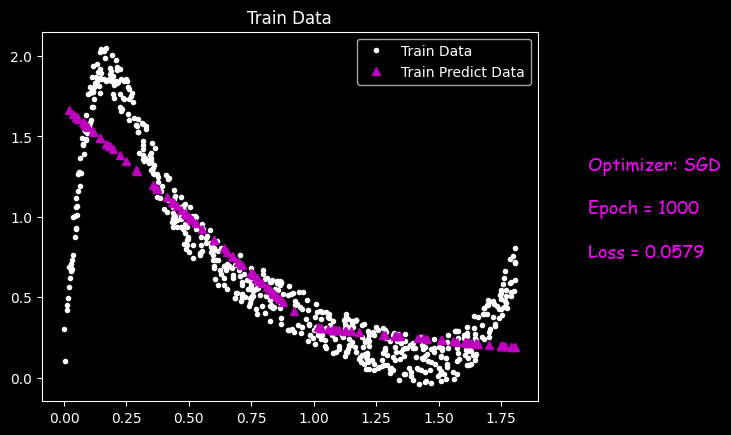

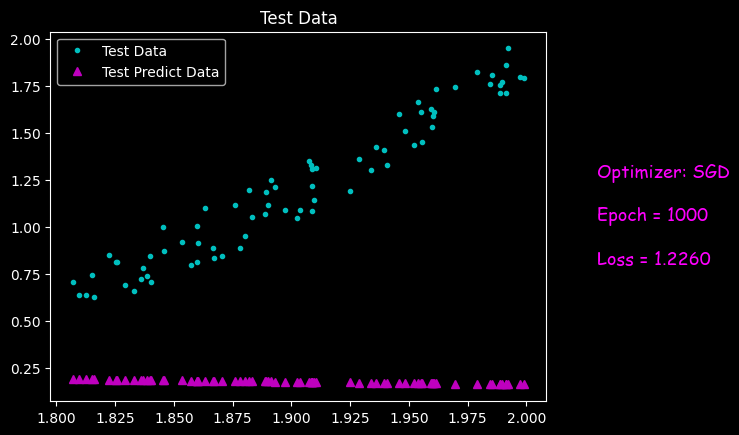

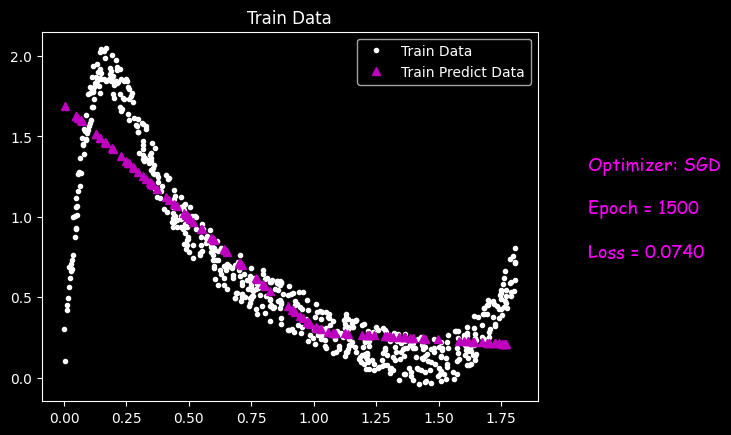

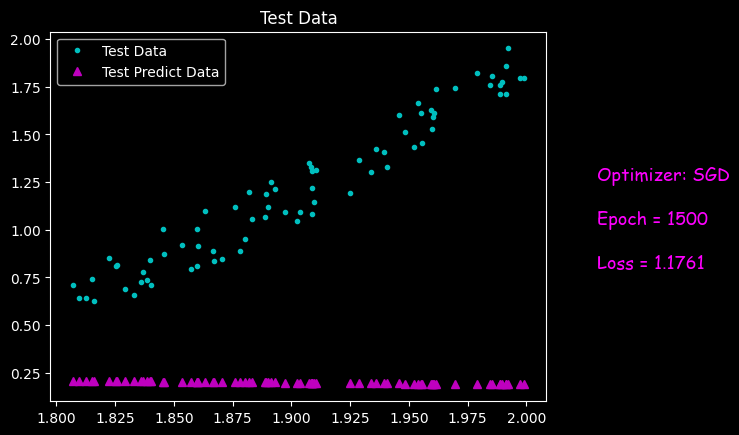

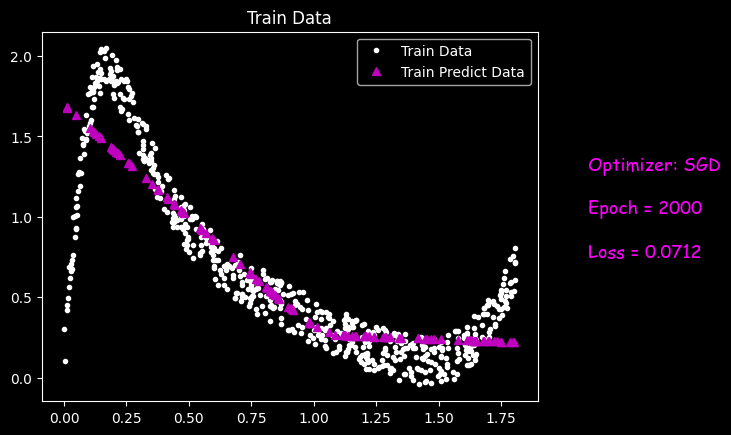

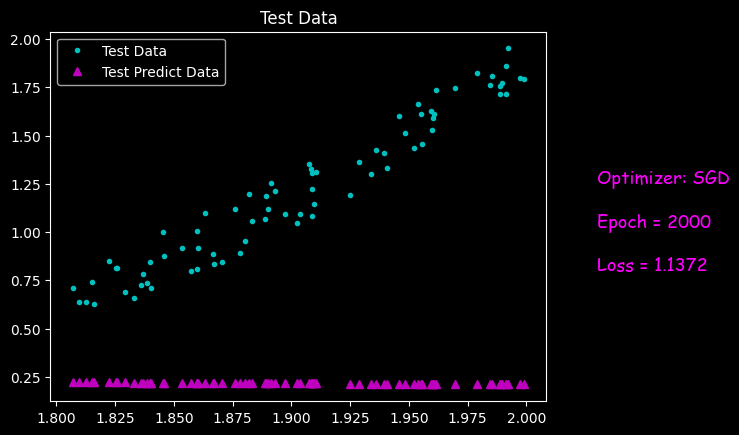

########################## TRAINING ON Reg_Net2 ##########################


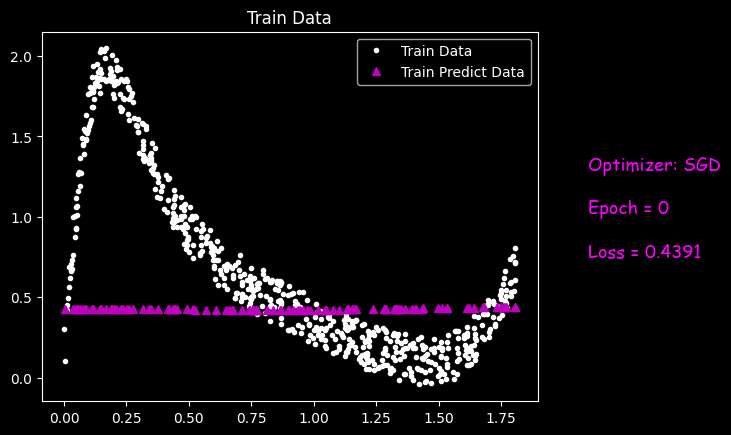

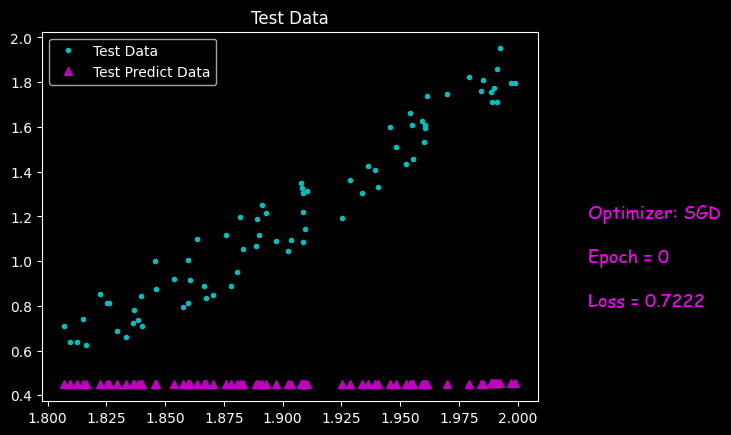

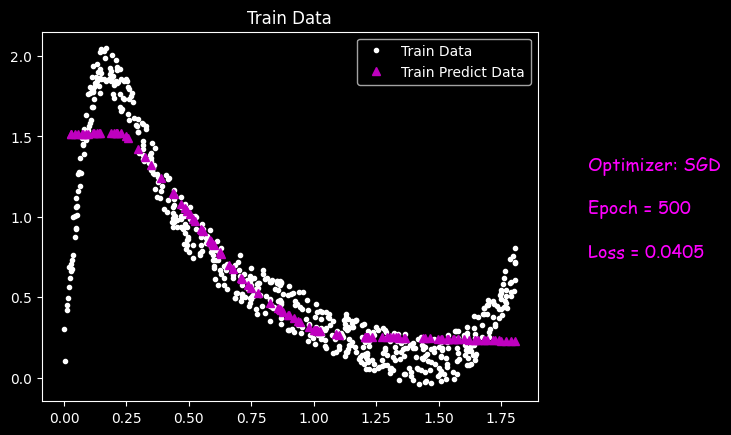

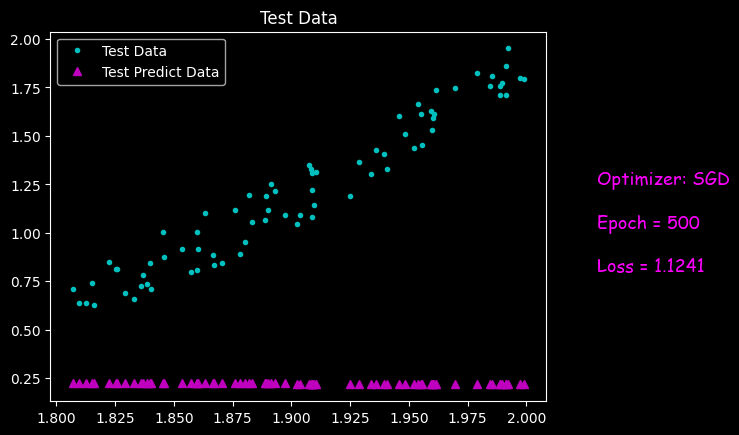

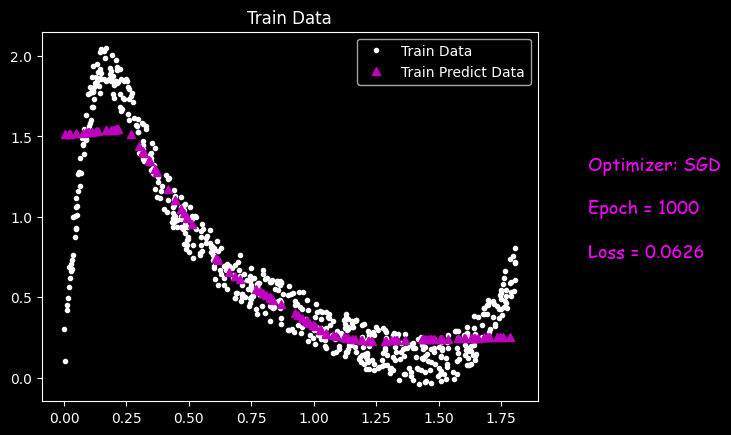

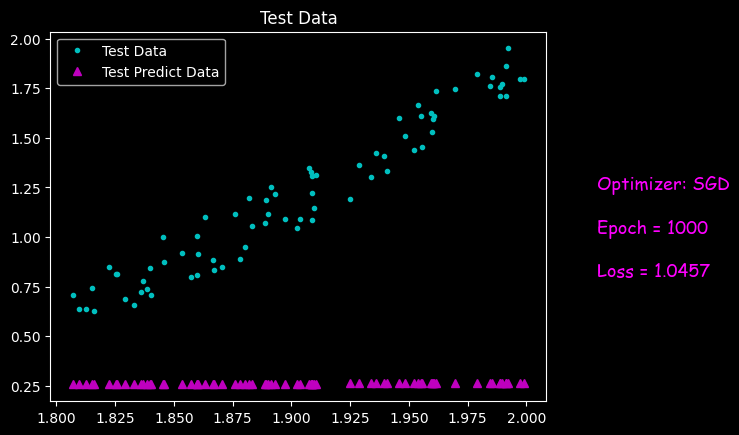

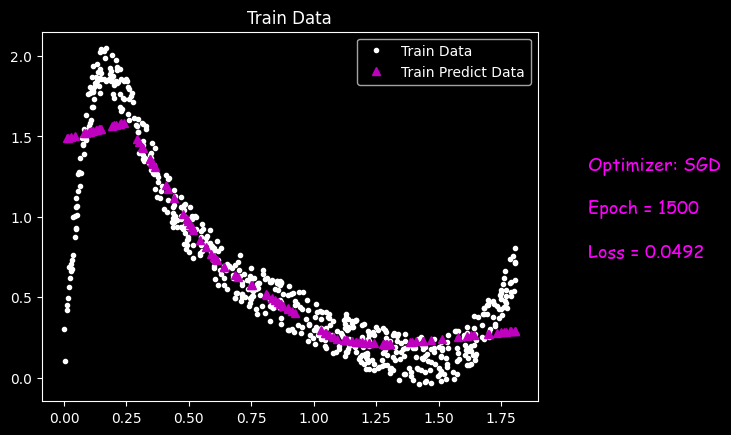

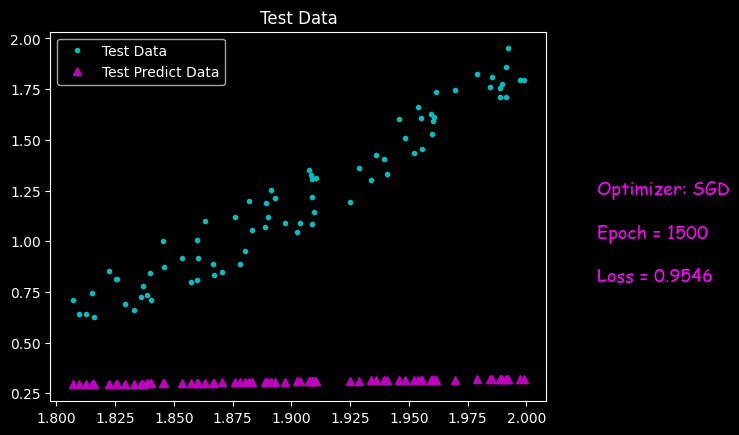

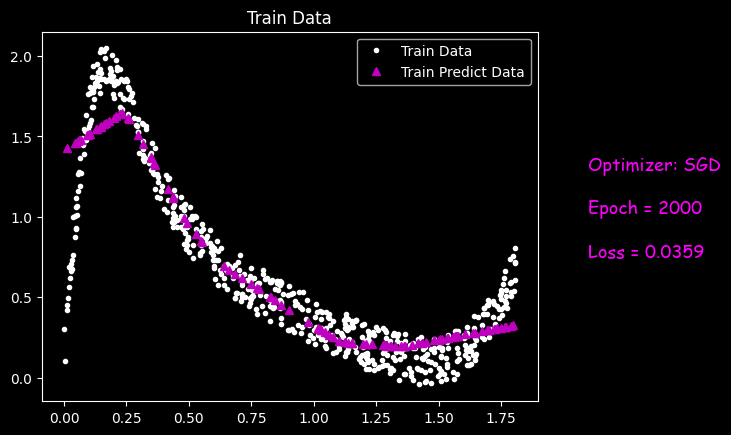

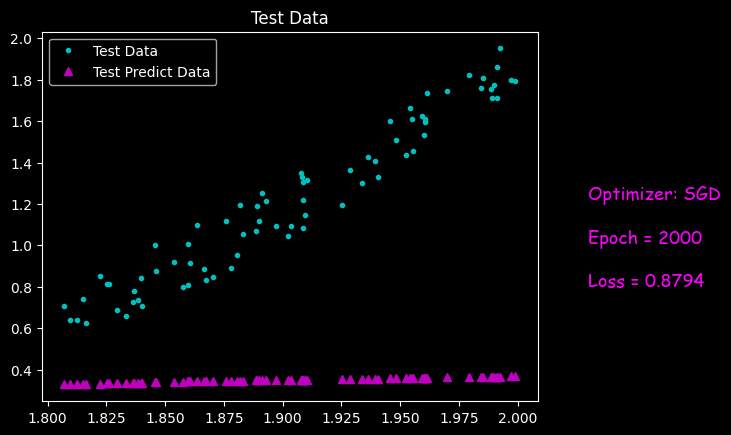

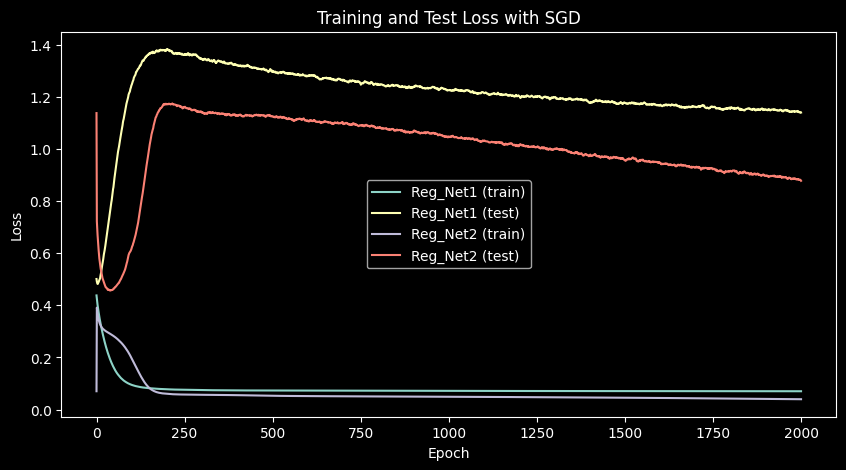

------------------------ Optimizer Adam training.. ------------------------

########################## TRAINING ON Reg_Net1 ##########################


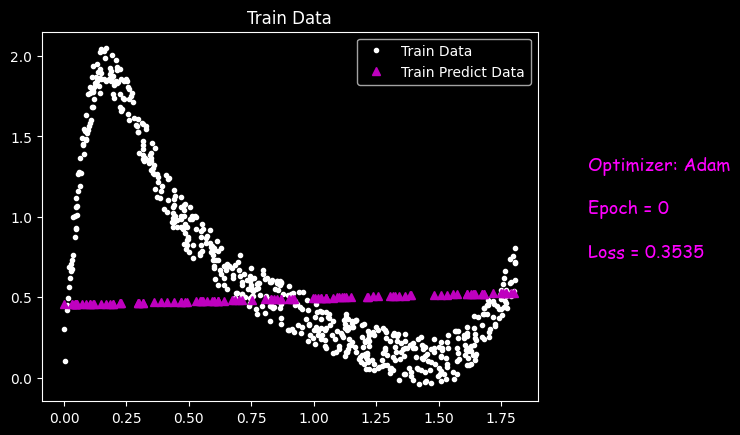

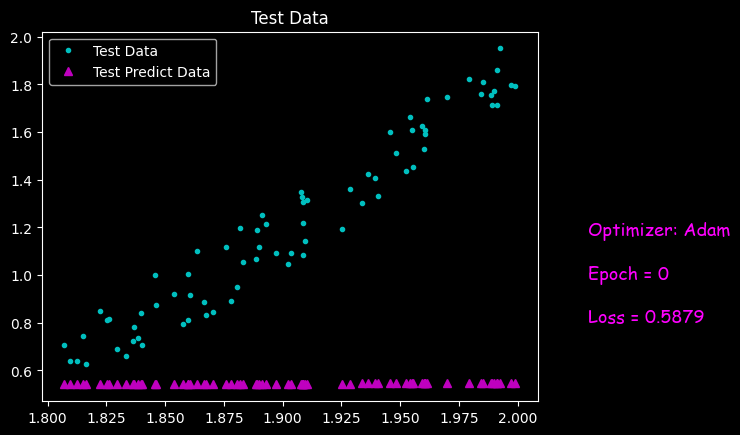

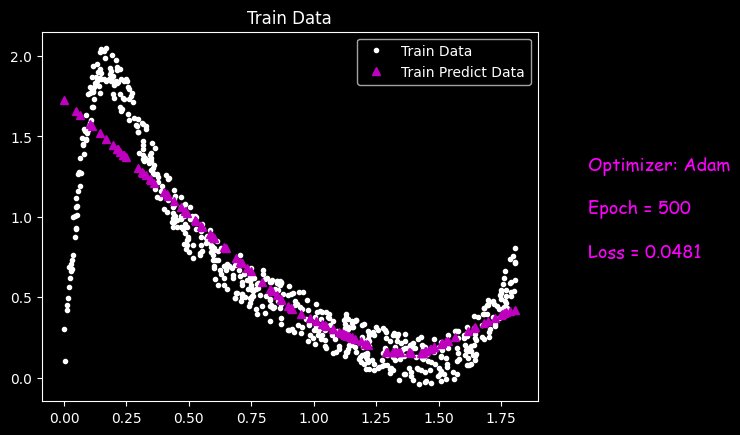

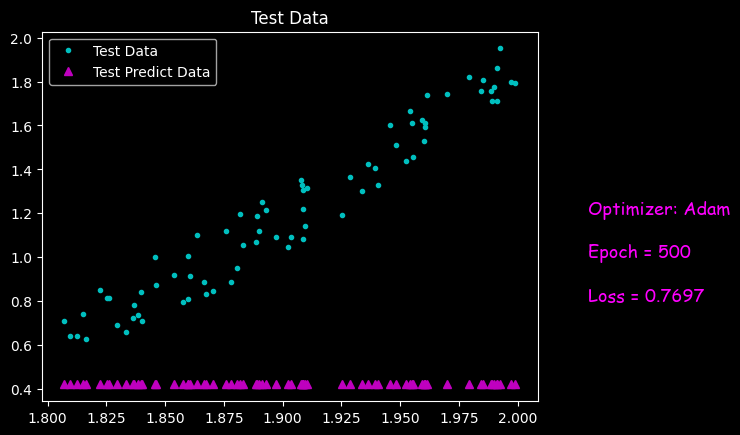

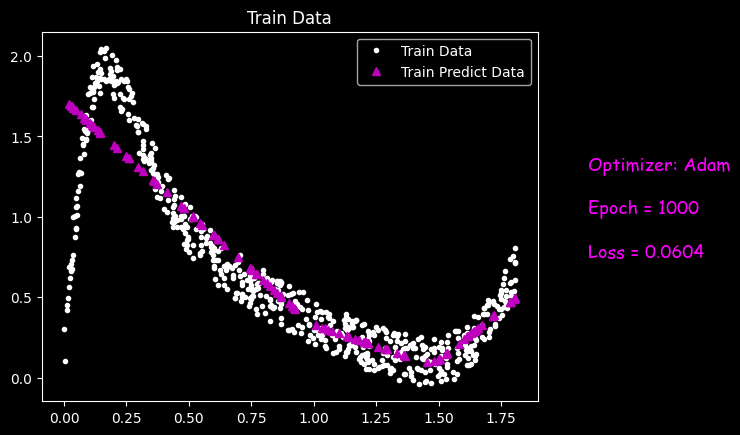

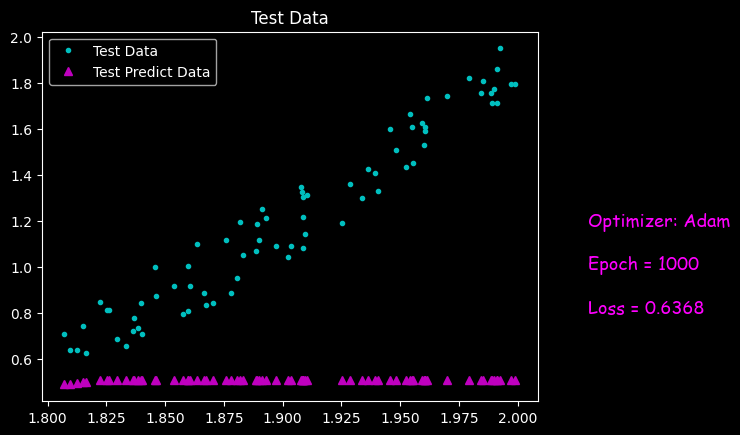

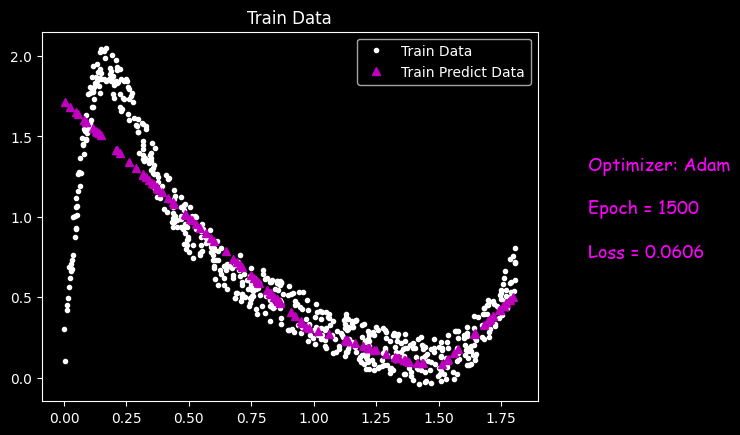

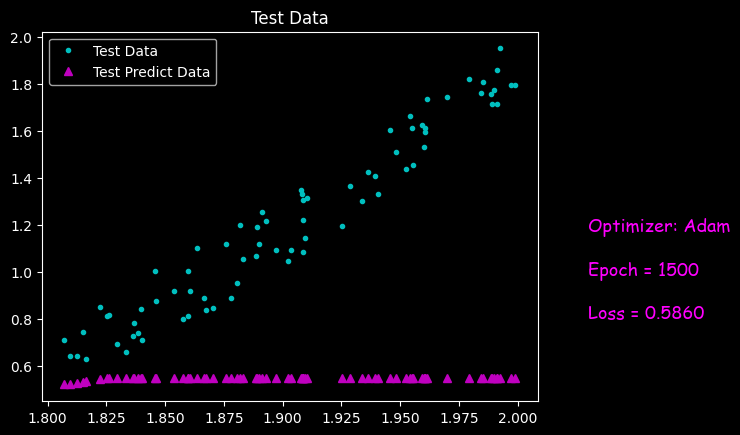

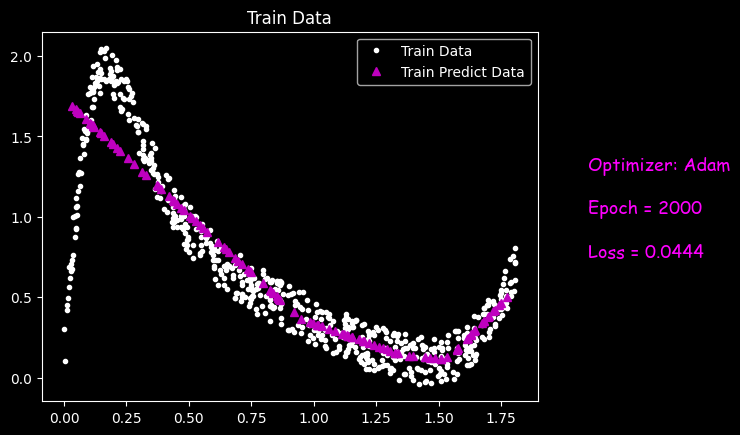

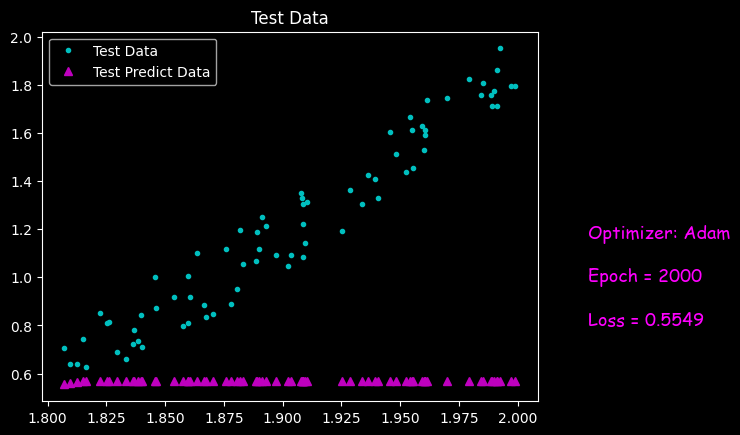

########################## TRAINING ON Reg_Net2 ##########################


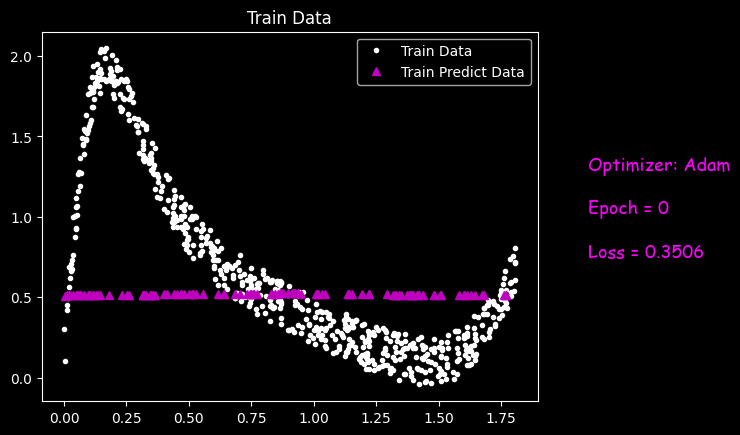

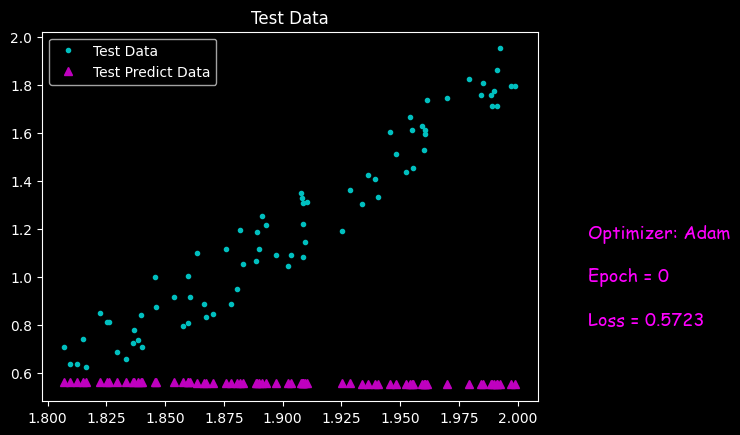

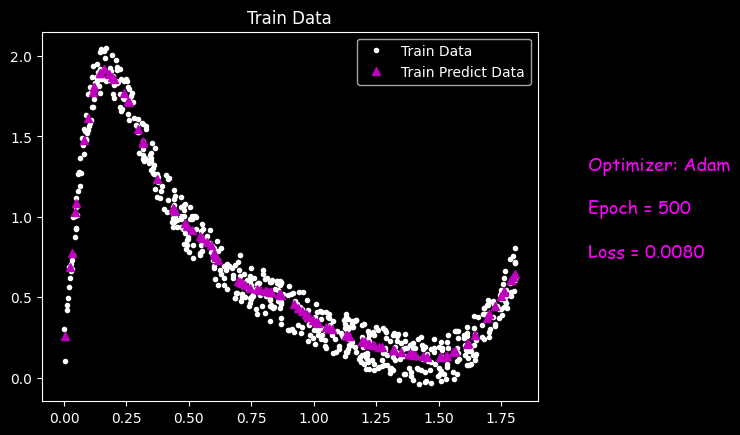

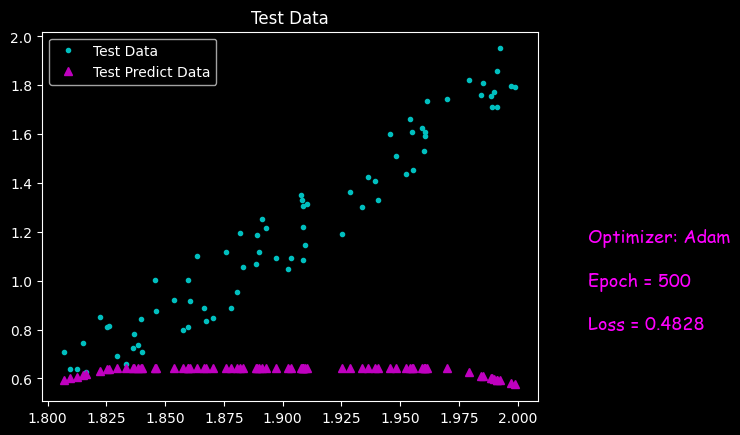

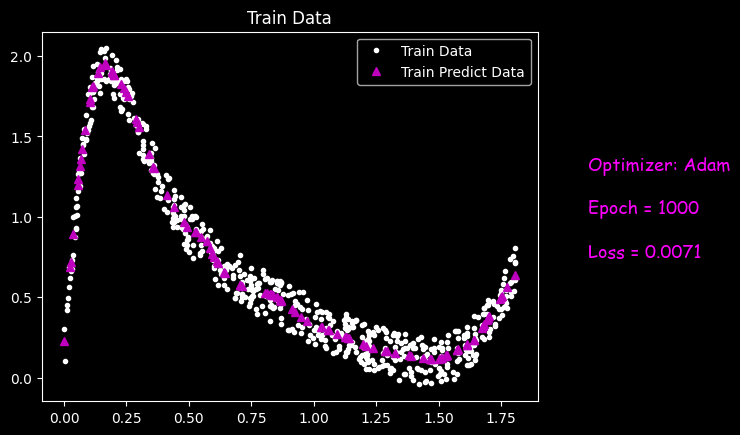

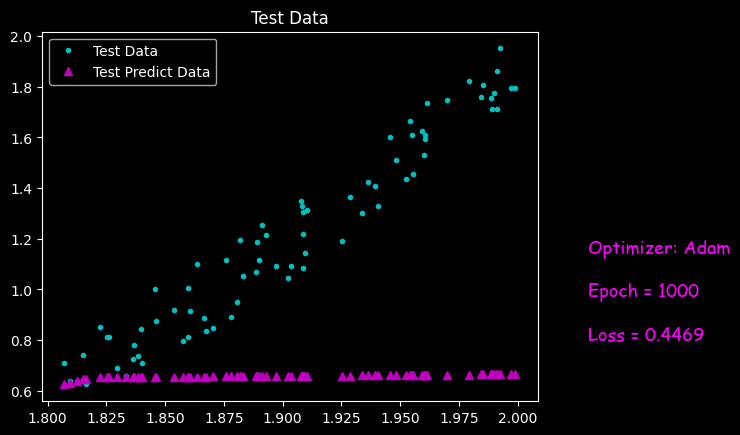

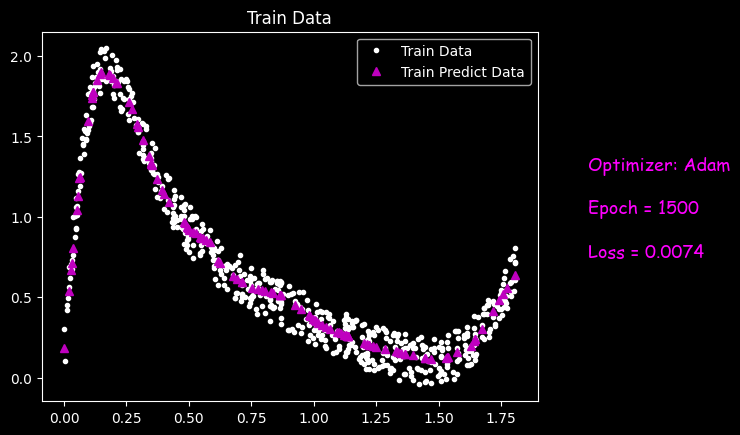

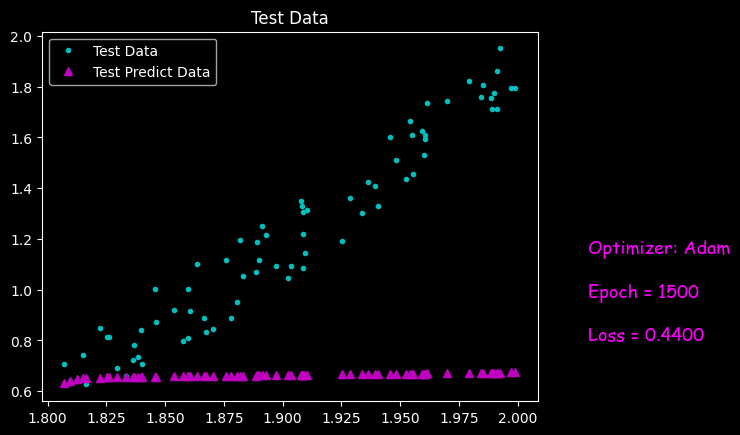

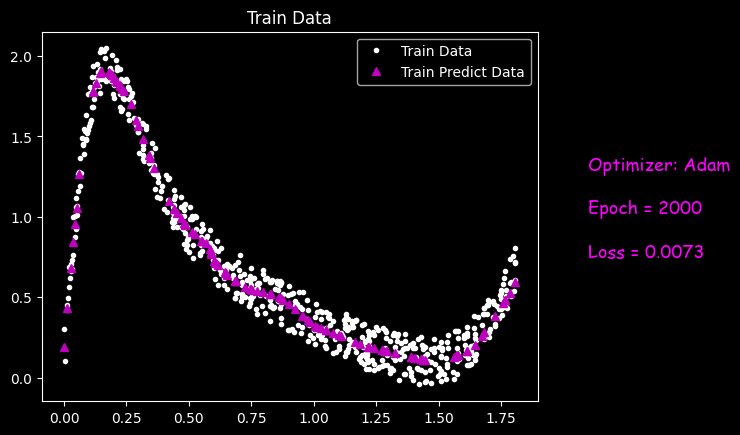

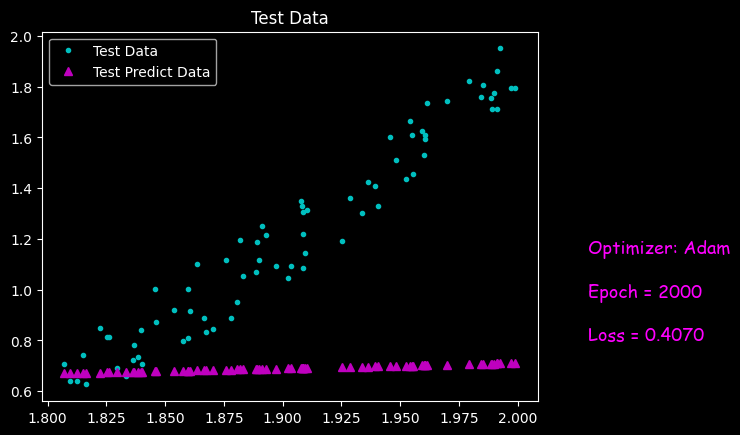

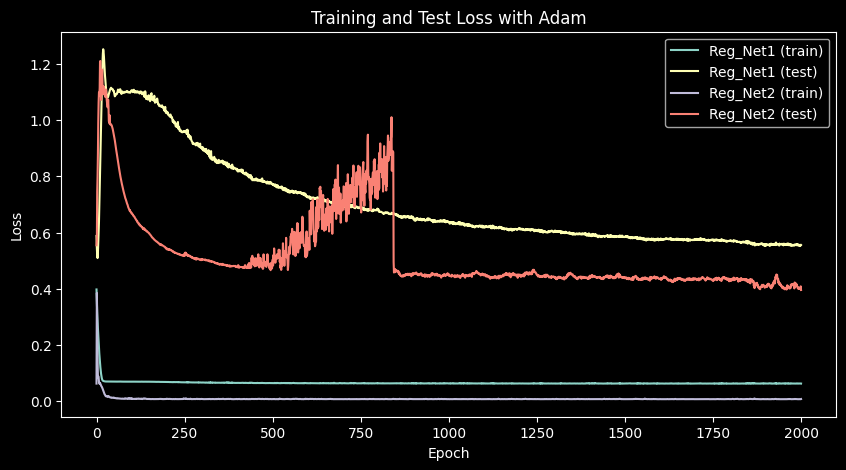

------------------------ Optimizer RMSprop training.. ------------------------

########################## TRAINING ON Reg_Net1 ##########################


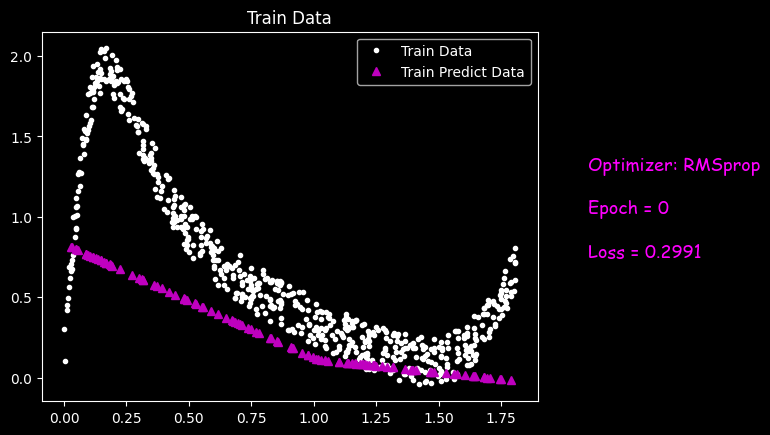

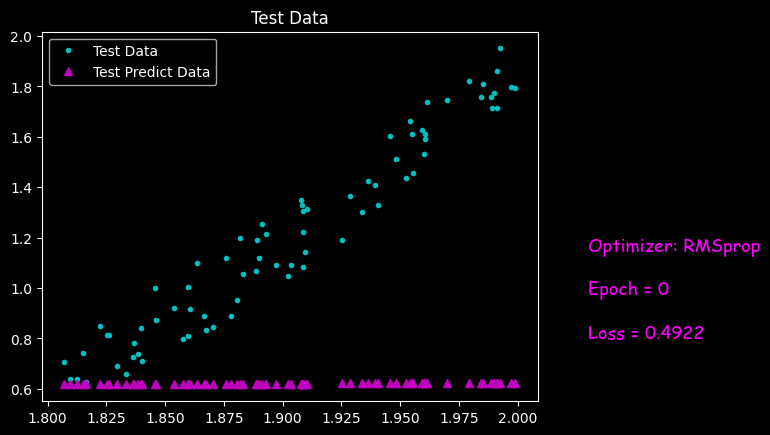

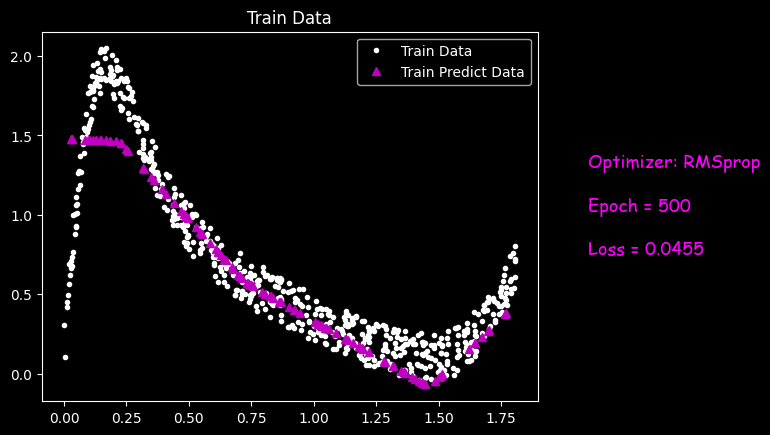

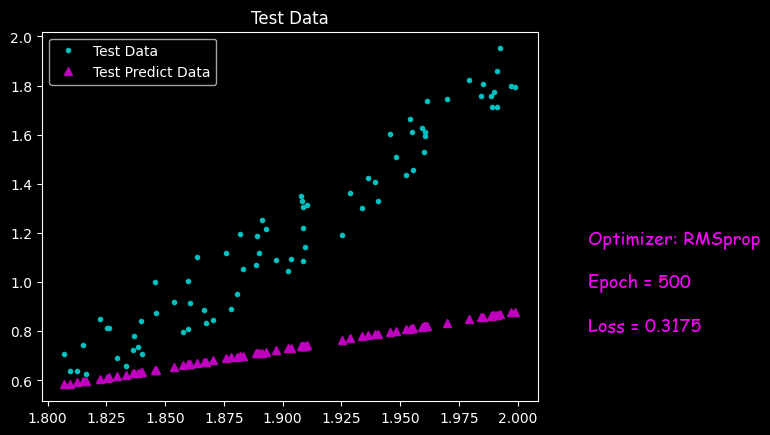

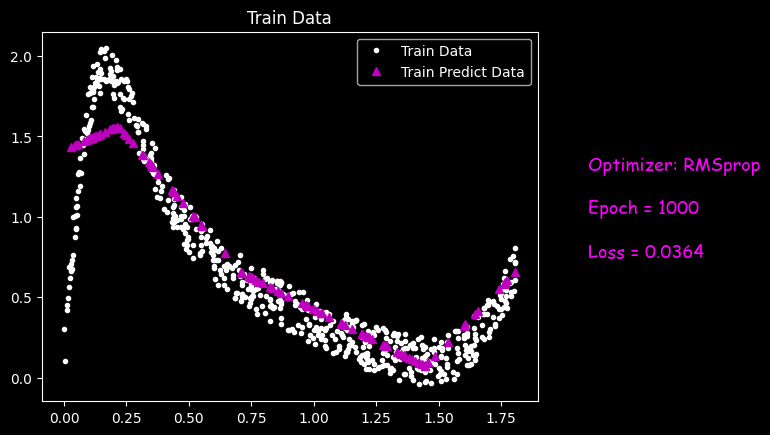

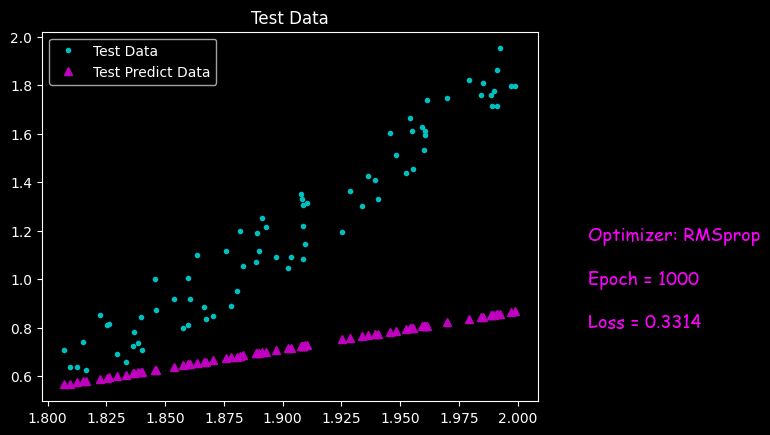

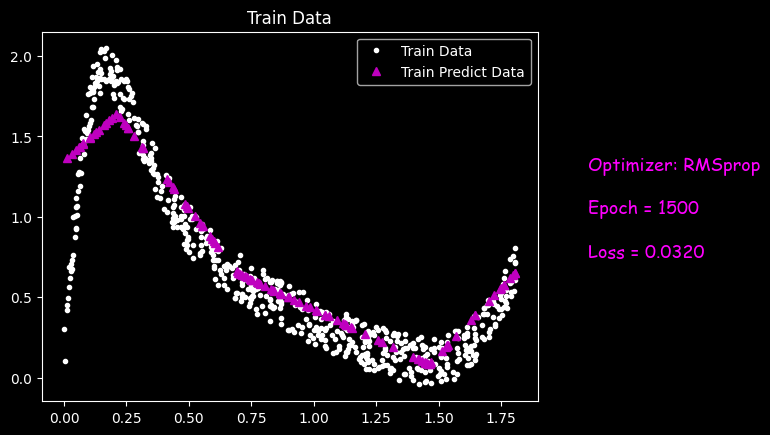

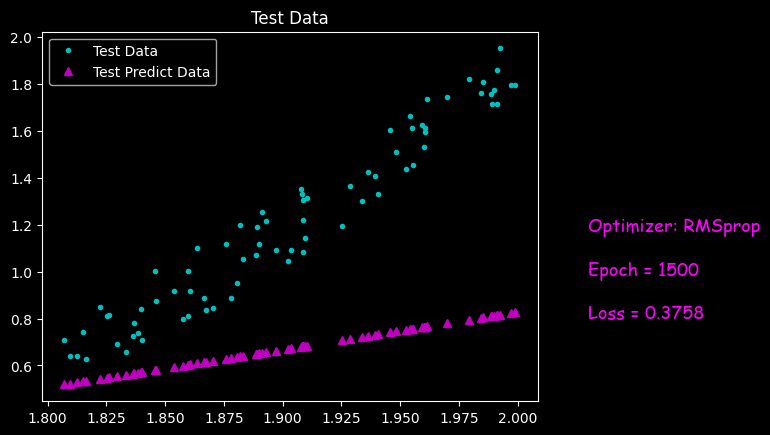

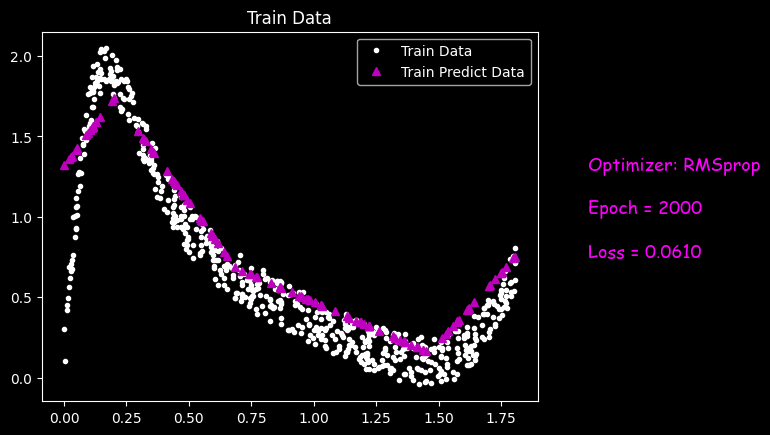

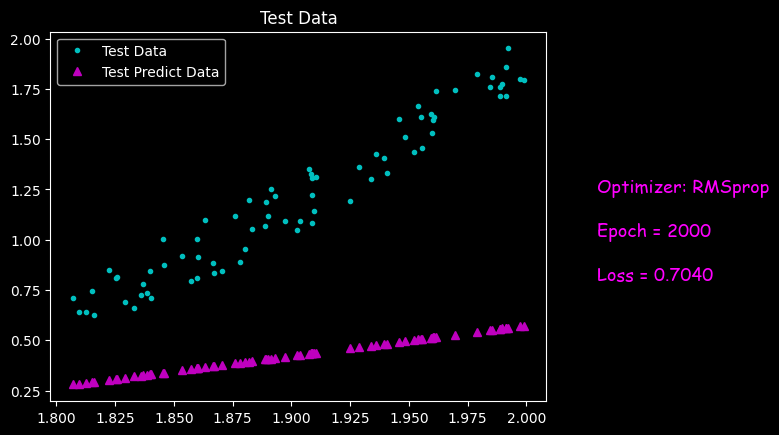

########################## TRAINING ON Reg_Net2 ##########################


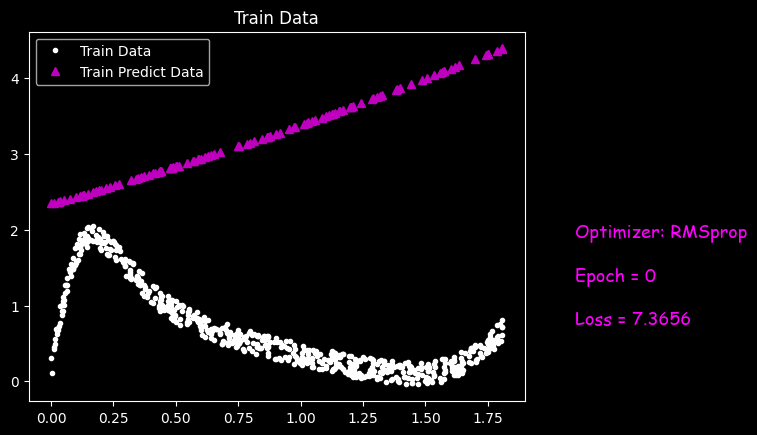

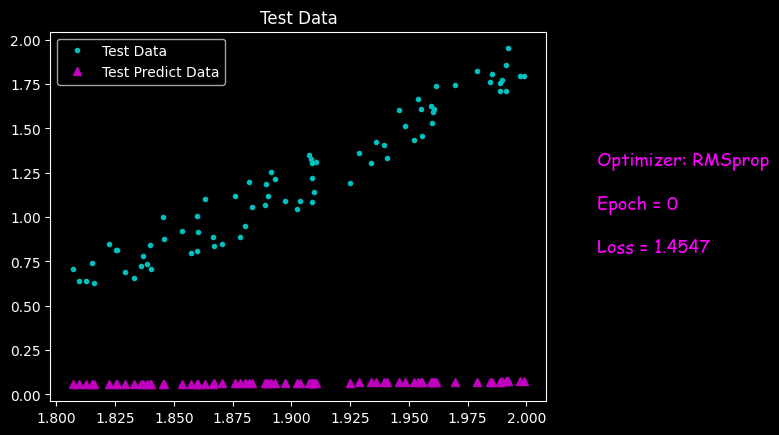

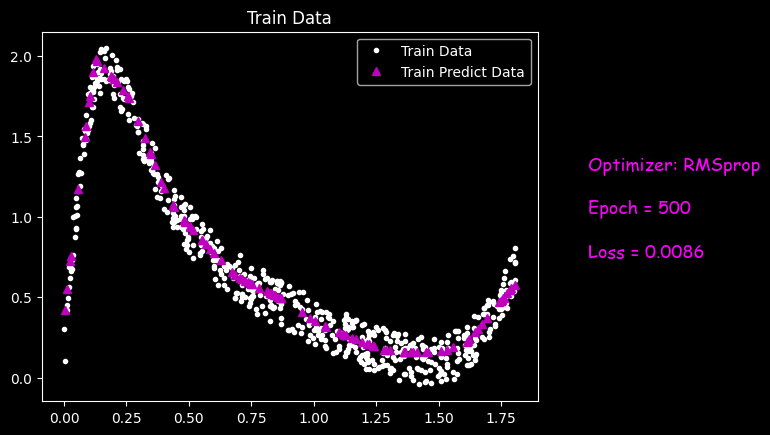

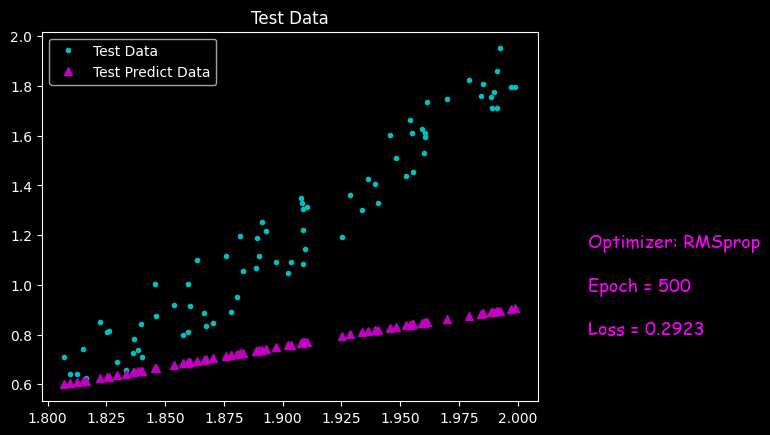

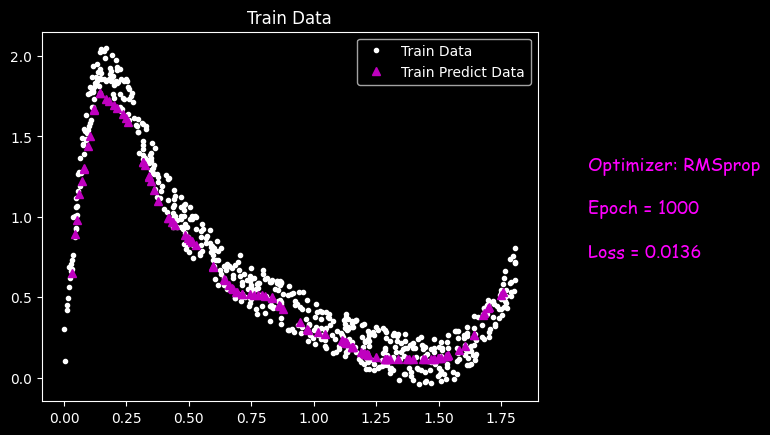

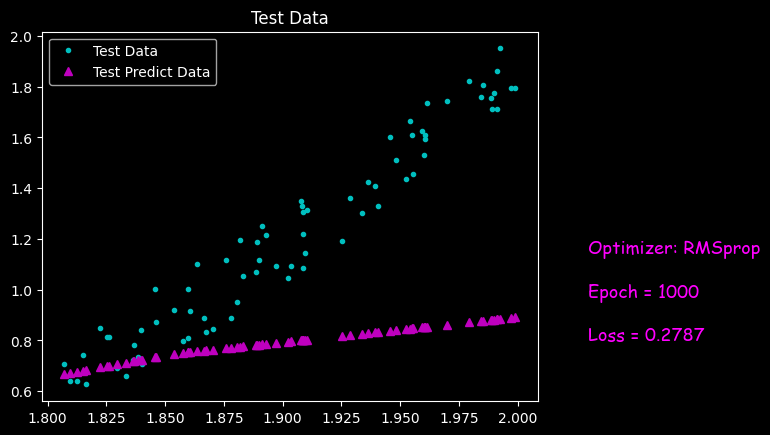

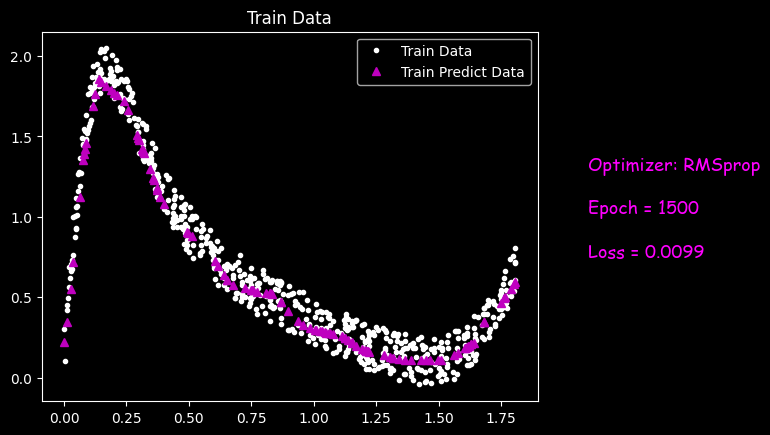

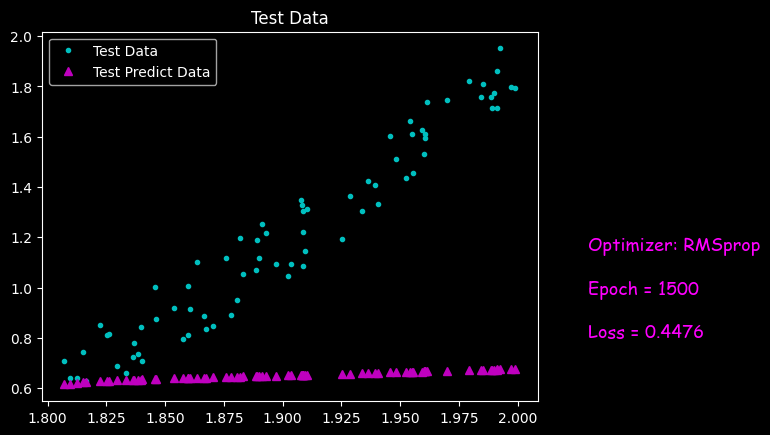

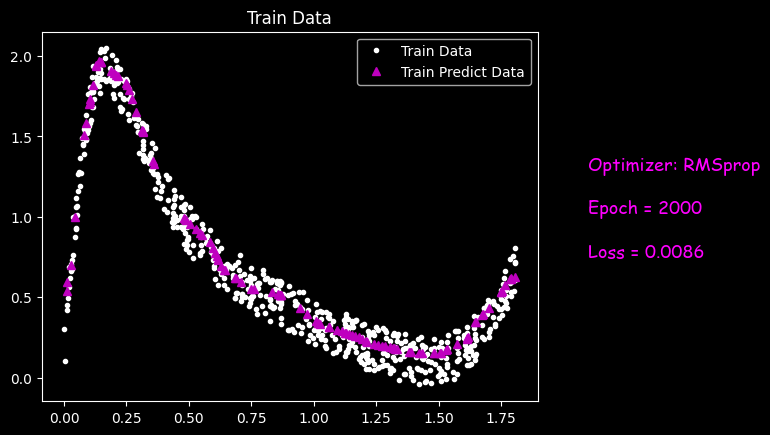

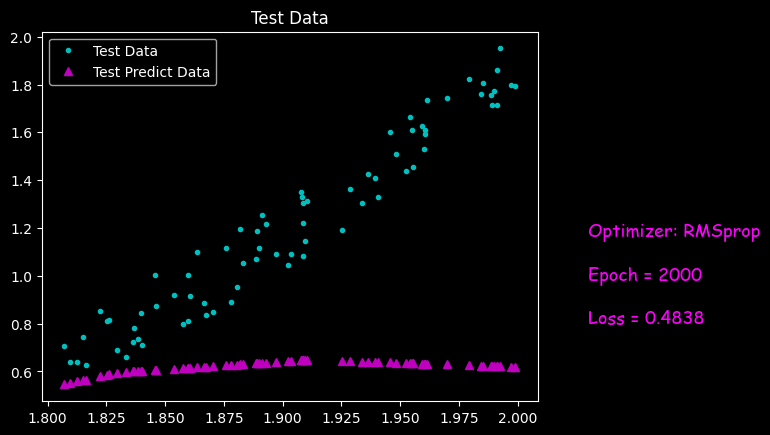

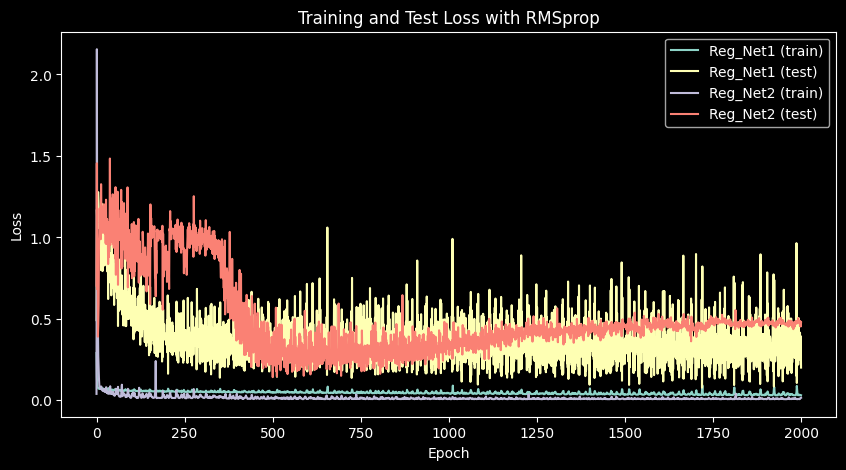

------------------------ Optimizer Adadelta training.. ------------------------

########################## TRAINING ON Reg_Net1 ##########################


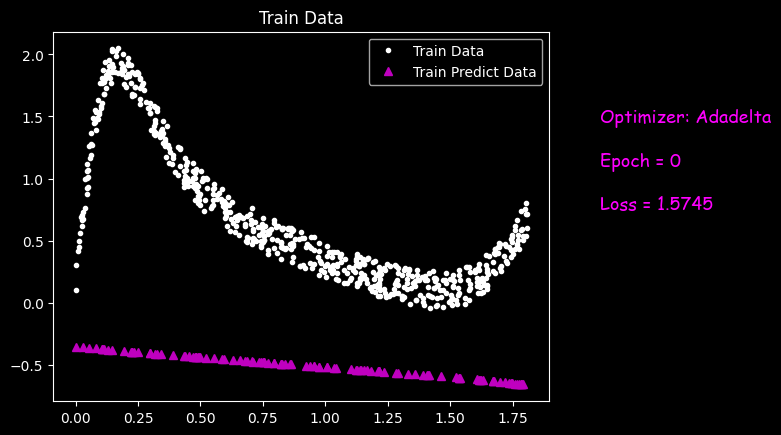

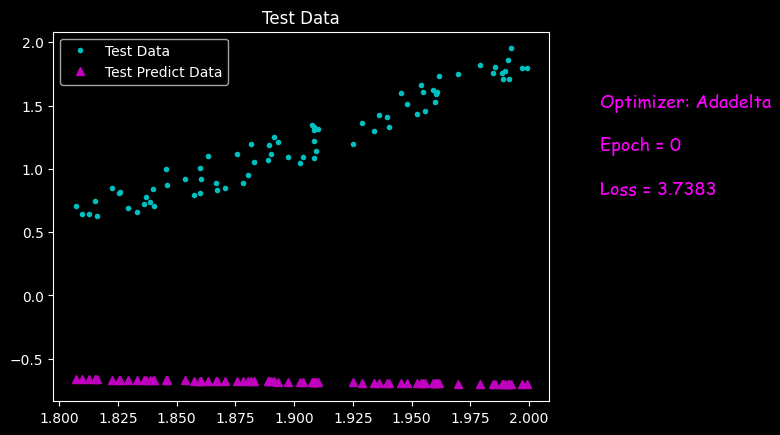

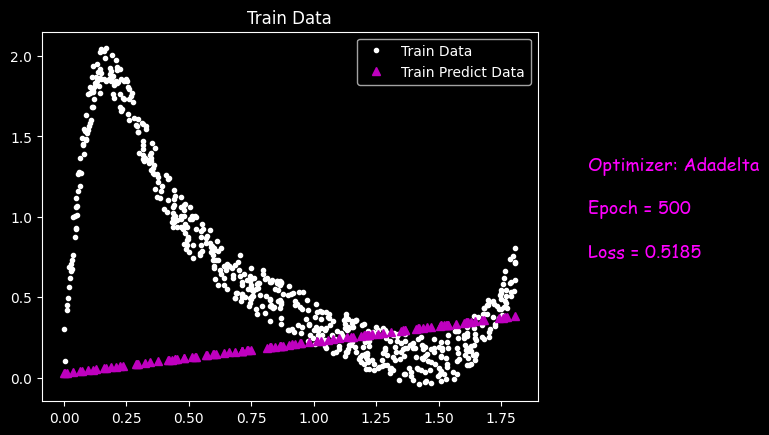

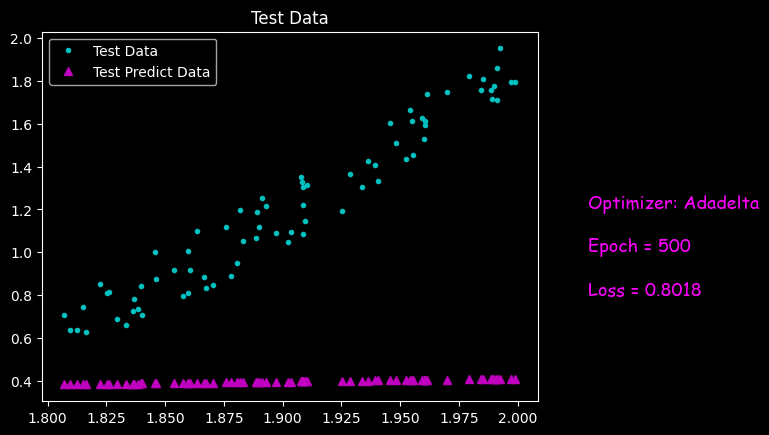

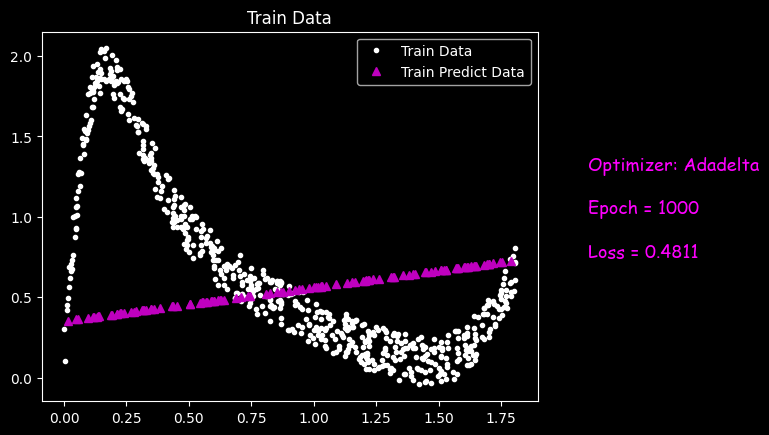

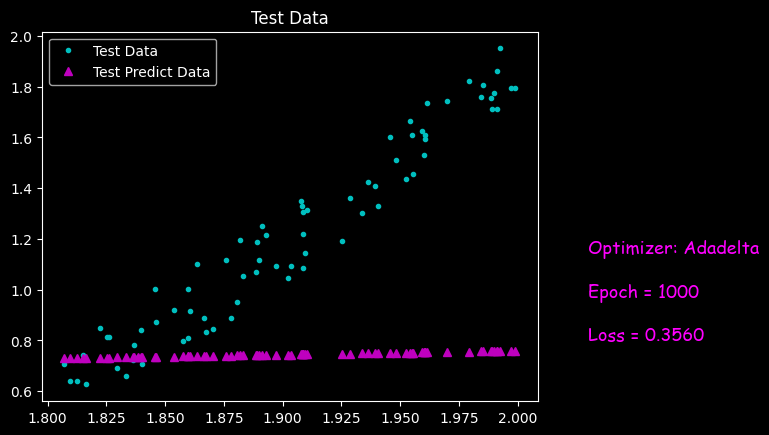

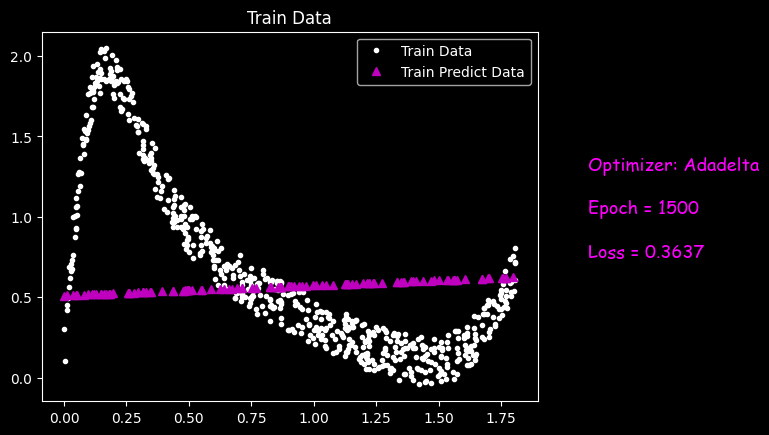

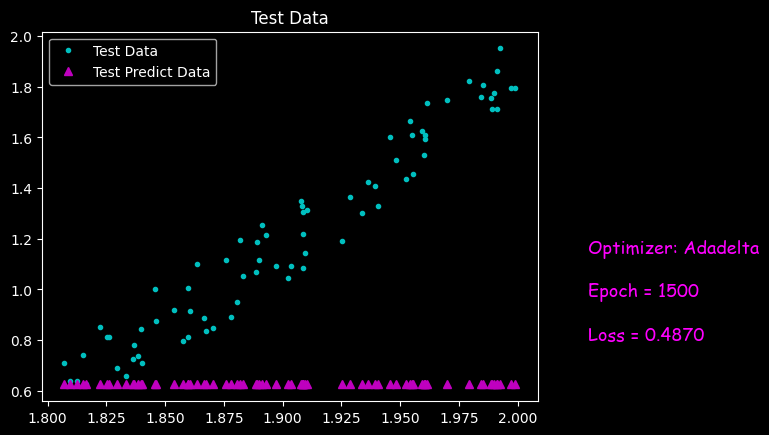

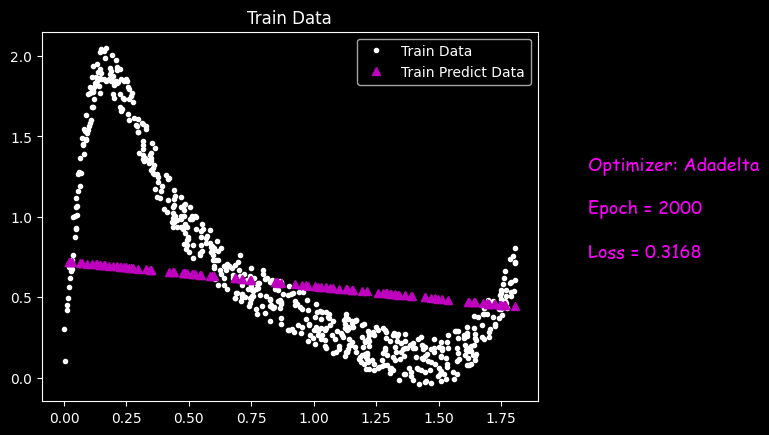

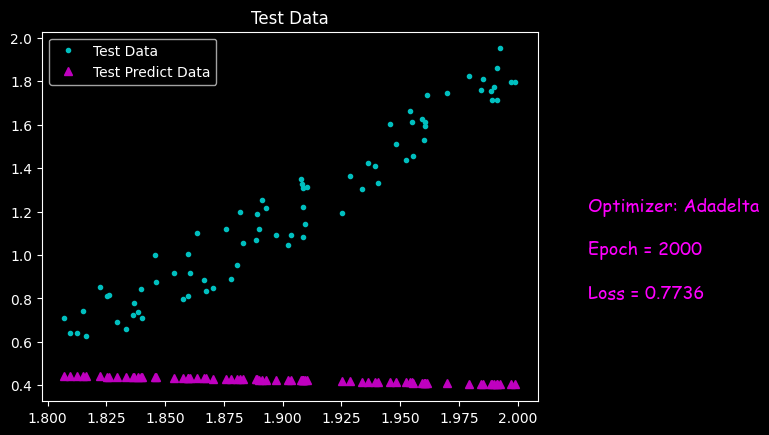

########################## TRAINING ON Reg_Net2 ##########################


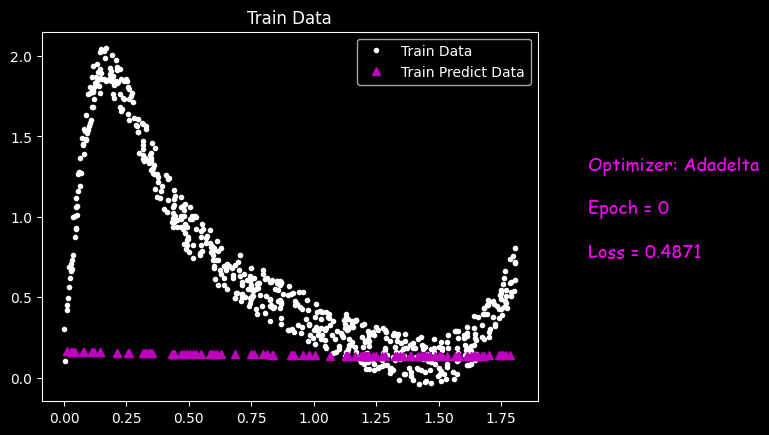

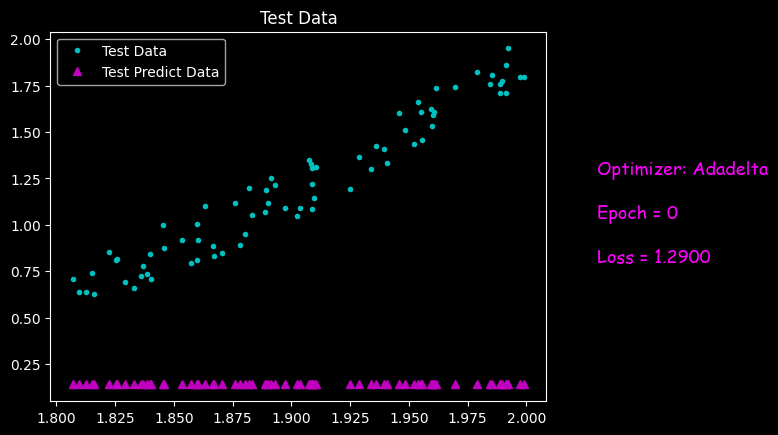

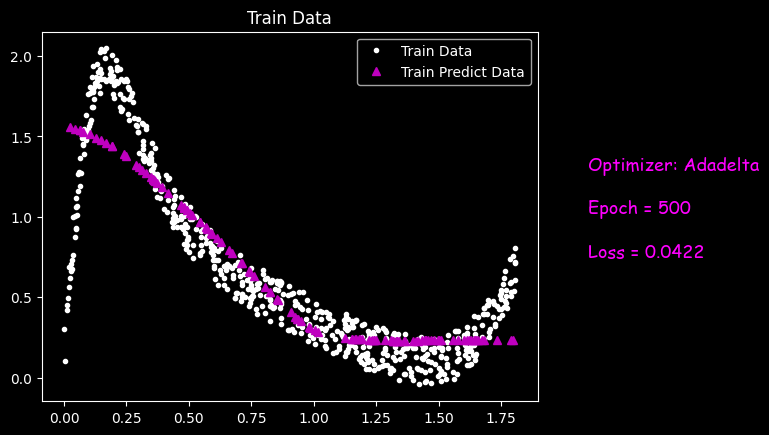

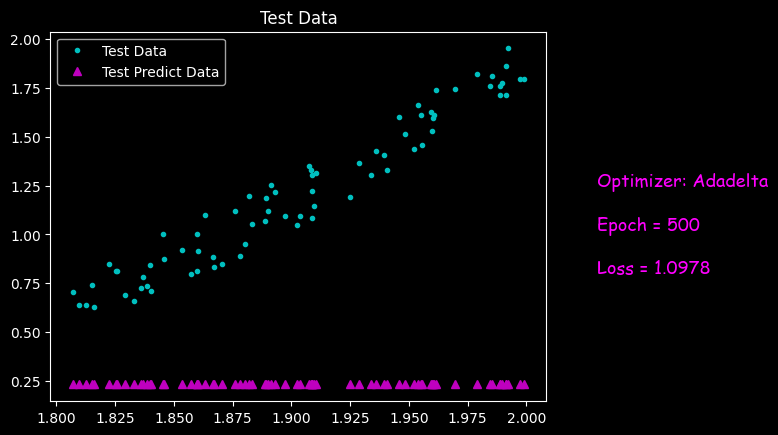

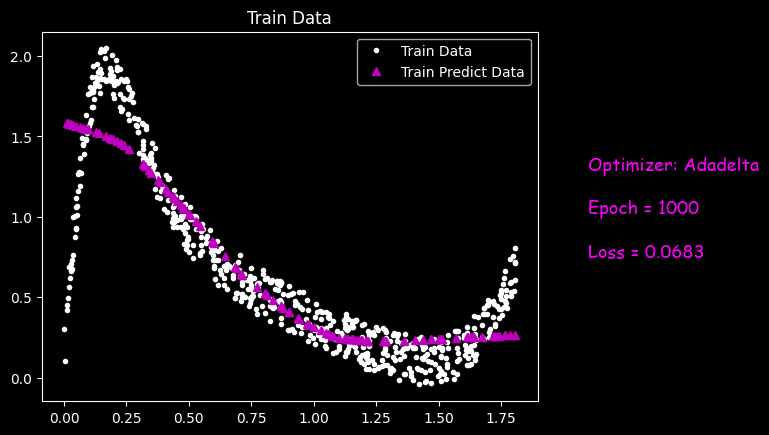

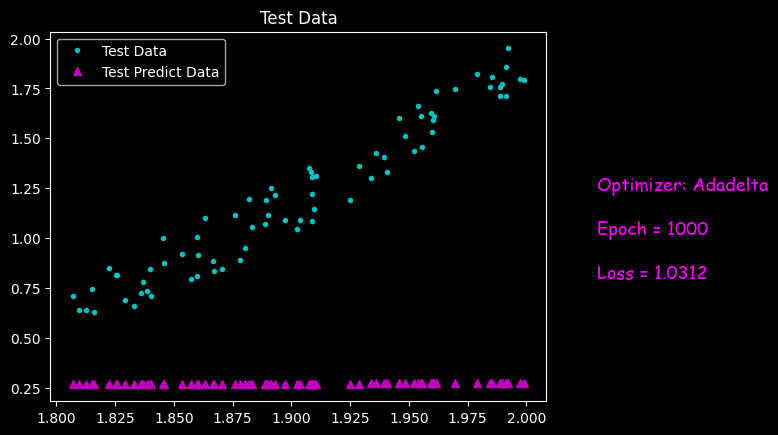

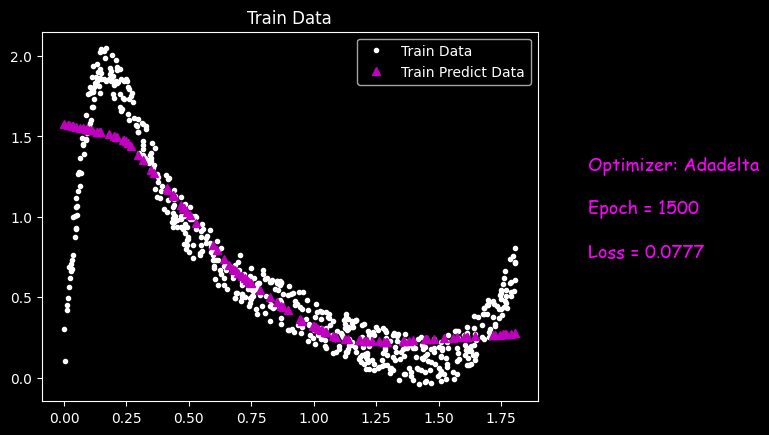

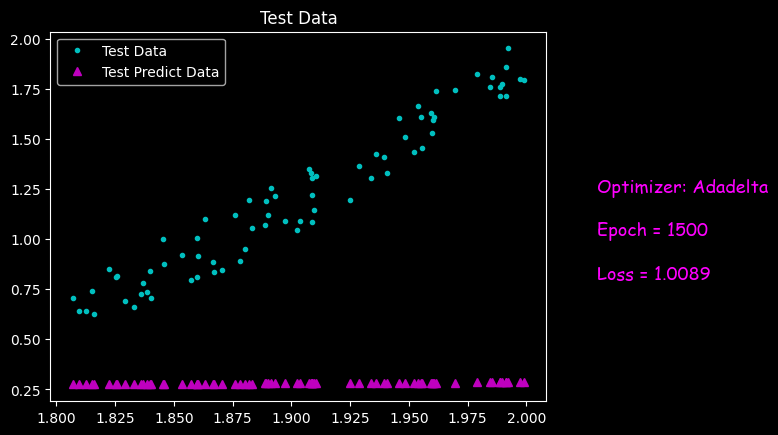

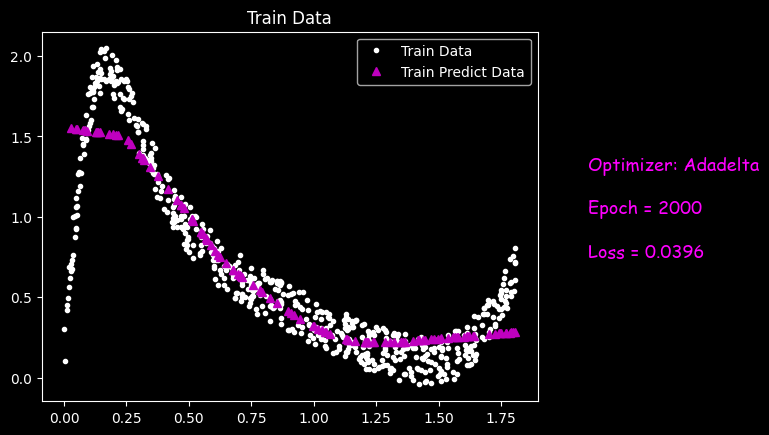

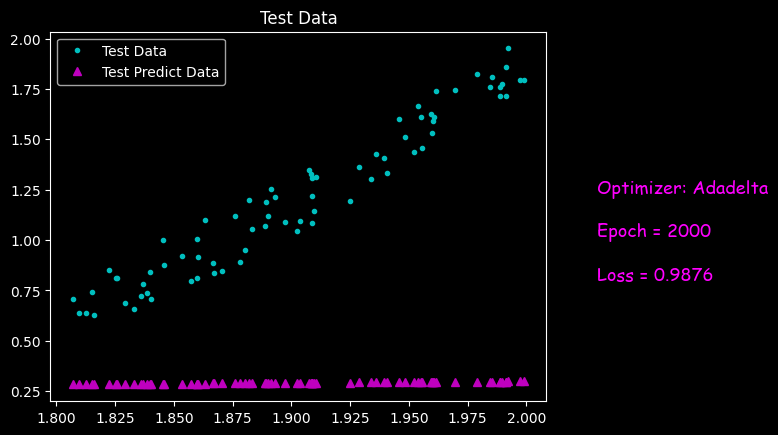

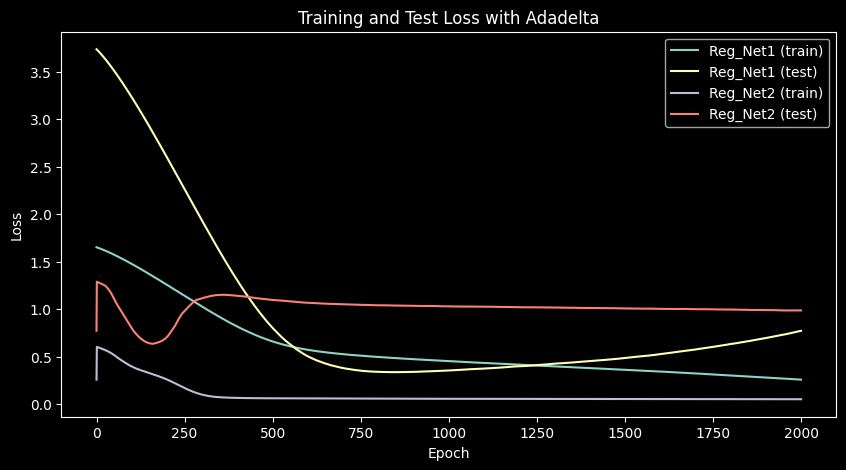

In [ ]:
for opt_name, opt in optimizers.items():
    print(f"------------------------ Optimizer {opt_name} training.. ------------------------\n")

    results = {"train_loss": [], "test_loss": []}

    for model in models:
        print(f"########################## TRAINING ON {model.__class__.__name__} ##########################")
        optimizer = opt(model.parameters(), learning_rate)

        result = train_regression(epoch, train_loader, test_loader, opt_name, optimizer, model, results, loss_func)

       

    regnet1 = Reg_Net1()
    regnet2 = Reg_Net2()
    models = [regnet1, regnet2]
     # Plot the results

    plt.figure(figsize=(10, 5))
    for i, model in enumerate(models):
        
        plt.plot(results["train_loss"][i*epoch:(i+1)*epoch], label=f"{model.__class__.__name__} (train)")
        plt.plot(results["test_loss"][i*epoch:(i+1)*epoch], label=f"{model.__class__.__name__} (test)")
    plt.title(f"Training and Test Loss with {opt_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()    


# RESULTS - REGRESSION

### Loss Charts All in One

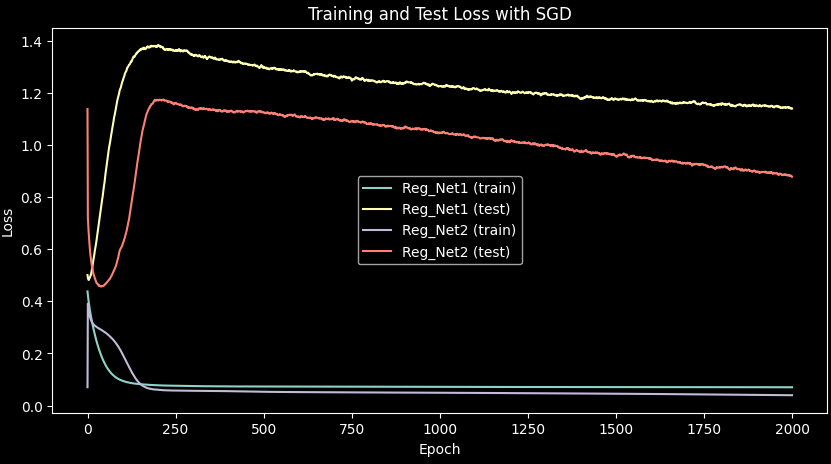

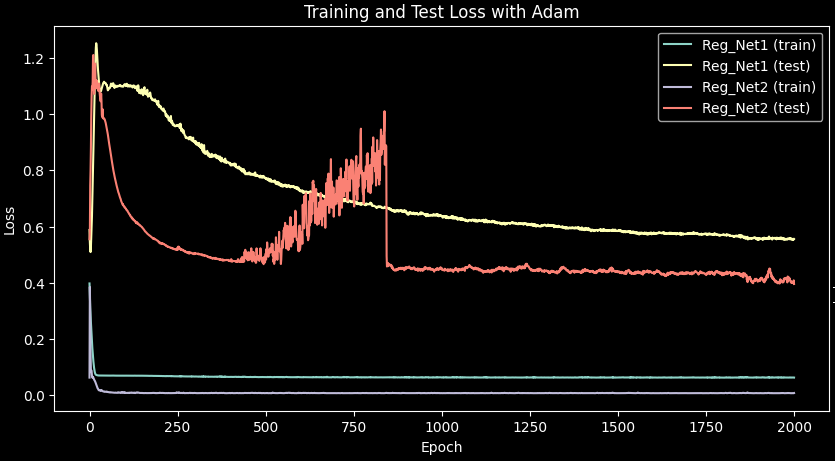

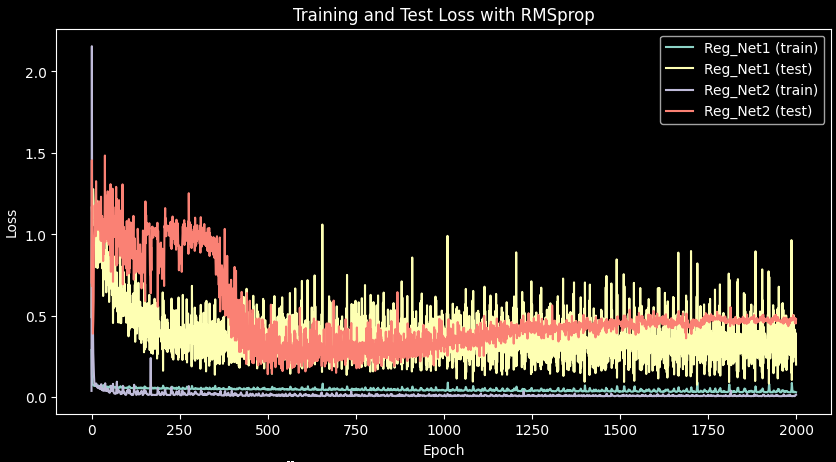

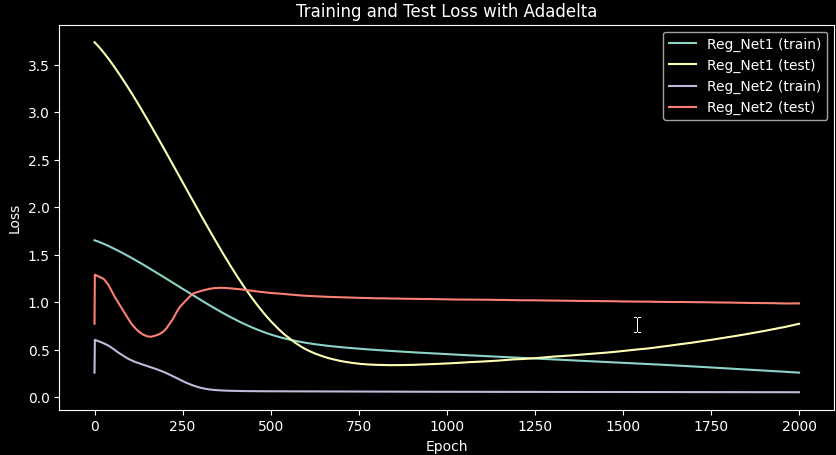

As we can see in the graphs, The network, which is the first to be trained for each optimizer and has a single hidden layer, is insufficient.
However, if you have to choose between them, Adam and RMSprop optimizer give the best results.

For the second trained more complex network, all but Adadelta give good results. However, looking at the test data, the RMSprop optimizer gave the best results.

Before adding the sine wave, Adam was also doing very well on the test data. However, after adding the sine wave, negative effects such as late coupling and larger error in the test data were observed.

Another problem with RMSprop is that it fluctuates too much as can be seen from the graph. Therefore, about 500 epochs should be completed without increasing the number of epochs too much.

On the other hand, we see that AdaDelta is not very successful. 

To sum up, it seems to be the most logical result that the most logical network to choose is the more complex optimizer' RMSprop.

---

# Classification Part

---

This part of the midterm is heavily copied from the Homework3

### Creating and preparing the dataset

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                       train=True, 
                       transform=torchvision.transforms.transforms.ToTensor(), 
                       download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                      train=False, 
                      transform=torchvision.transforms.transforms.ToTensor())


test_data = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=True, pin_memory=True)


train_subset, val_subset = torch.utils.data.random_split(train_dataset, [40000, 20000], generator=torch.Generator().manual_seed(42))

train_data = DataLoader(dataset=train_subset, shuffle=True, batch_size=32, pin_memory=True)
val_data = DataLoader(dataset=val_subset, shuffle=True, batch_size=32, pin_memory=True)

### Visualize the Data

### Defining the Classification Net

In [ ]:
class Class_Net1(nn.Module):
    def __init__(self):
        super(Class_Net1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
    
class Class_Net2(nn.Module):
    def __init__(self):
        super(Class_Net2, self).__init__()
        self.flatten = nn.Flatten()
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = self.tanh(x)
        x = self.fc4(x)
        x = self.tanh(x)
        x = self.fc5(x)
        x = self.softmax(x)
        return x
    

## Training Function

In [ ]:
# Train Function
def train_classification(epochs, train_data, val_data, optimizer, model, criterion):

    # Lists for the accuracy and loss
    loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    
    # Training part
    for epoch in range(epochs):
        lossRun = 0
        correct = 0        
        for data, target in train_data:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad() # zero the gradients
            output = model(data) # forward pass
            loss = criterion(output, target) # calculate loss
            loss.backward() # backward pass
            optimizer.step() # update weights
            lossRun += loss.item() * data.size(0)

            # Compute the training accuracy
            predicted = output.argmax(dim=1, keepdim=True)
            correct += predicted.eq(target.view_as(predicted)).sum().item()

        # Calculating the training accuracy for this epoch
        train_acc =  100 * (correct / len(train_data.dataset))
        train_acc_list.append(train_acc)
            
        # Calculating the training loss for this epoch
        lossValue = lossRun / len(train_data.dataset)
        loss_list.append(lossValue)



        # Calculating validation accuracy and loss
        valid_loss = 0.0
        correct = 0
        with torch.no_grad():
            for data, target in val_data:
                data, target = data.to(device), target.to(device)

                outputs = model(data)
                loss = criterion(outputs, target)
                valid_loss += loss.item() * data.size(0)

                predicted = outputs.argmax(dim=1, keepdim=True)
                correct += predicted.eq(target.view_as(predicted)).sum().item()

            # Validation accuracy
            valid_acc = 100 * (correct / len(val_data.dataset))
            val_acc_list.append(valid_acc)    
            # Validation loss
            valid_loss /= len(val_data.dataset)
            val_loss_list.append(valid_loss)
            
        if epoch % 10 == 0 or epoch+1 == 80:
        # Print values at the end of the each epoch
          print("Epoch %d - loss: %.4f - accuracy: %.4f - val_loss: %.4f - val_accuracy: %.4f" % (epoch, loss_list[-1], train_acc_list[-1], val_loss_list[-1], val_acc_list[-1]))
    
    # Returning the lists
    return loss_list, train_acc_list, val_loss_list, val_acc_list



## Test Function

In [ ]:
# Test Function
def test(model, corr=0, corr_val=0, tot=0, tot_val=0):
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0

    with torch.no_grad():
        for data, target in test_data:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item() * data.size(0)

            predicted = outputs.argmax(dim=1, keepdim=True)
            corr += predicted.eq(target.view_as(predicted)).sum().item()           

        # Accuracy calculation
        testAcc = 100 * (corr / len(test_data.dataset))
        test_loss /= len(test_data.dataset)

    print(f"\nModel {model.__class__.__name__} Test Loss: {test_loss}")
    print(f"Model {model.__class__.__name__} Test Accuracy: %{testAcc}\n")
    


### Hyperparameters

In [ ]:
learning_rate = 0.001
epoch = 80

classnet1 = Class_Net1().to(device=device)
classnet2 = Class_Net2().to(device=device)


models = [classnet1, classnet2]

loss_func = nn.CrossEntropyLoss()

optimizers = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam,
    "RMSprop": torch.optim.RMSprop,
    "AdaDelta": torch.optim.Adadelta,
    "AdaGrad": torch.optim.Adagrad
}

## Iterating Over the Optimizers and Models and Visualizing Their Performance

I am visualizing the learning process (loss and accuracy values) after every optimizer and network changes.


############################## Optimizer SGD training.. ##############################


------------------------------- TRAINING ON Class_Net1 -------------------------------
Learning rate: 0.01
Epoch 0 - loss: 2.3016 - accuracy: 10.8025 - val_loss: 2.3002 - val_accuracy: 12.6050
Epoch 10 - loss: 1.7269 - accuracy: 74.5275 - val_loss: 1.7246 - val_accuracy: 74.4450
Epoch 20 - loss: 1.6366 - accuracy: 83.6400 - val_loss: 1.6395 - val_accuracy: 83.1950
Epoch 30 - loss: 1.6168 - accuracy: 84.9950 - val_loss: 1.6236 - val_accuracy: 84.2300
Epoch 40 - loss: 1.6089 - accuracy: 85.6775 - val_loss: 1.6173 - val_accuracy: 84.6950
Epoch 50 - loss: 1.6035 - accuracy: 86.1400 - val_loss: 1.6126 - val_accuracy: 85.1600
Epoch 60 - loss: 1.5992 - accuracy: 86.5575 - val_loss: 1.6094 - val_accuracy: 85.4550
Epoch 70 - loss: 1.5957 - accuracy: 86.9200 - val_loss: 1.6065 - val_accuracy: 85.6900
Epoch 79 - loss: 1.5930 - accuracy: 87.1400 - val_loss: 1.6043 - val_accuracy: 85.8350

Model Class_Net1 Test

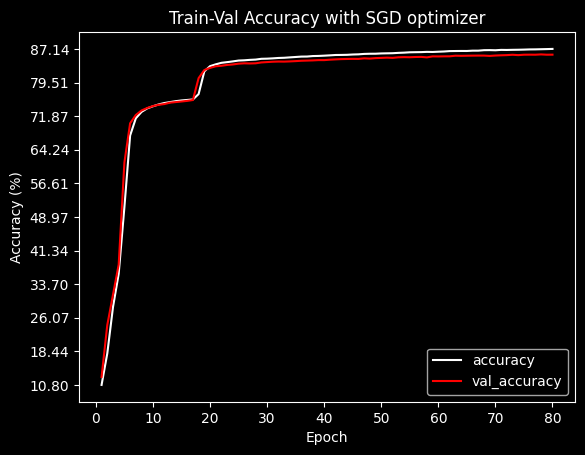

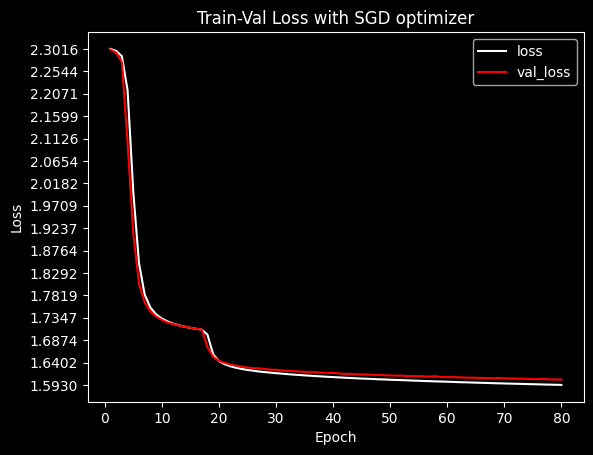


------------------------------- TRAINING ON Class_Net2 -------------------------------
Learning rate: 0.01
Epoch 0 - loss: 2.3012 - accuracy: 9.9625 - val_loss: 2.2994 - val_accuracy: 9.7400
Epoch 10 - loss: 1.7876 - accuracy: 72.3900 - val_loss: 1.7583 - val_accuracy: 76.1800
Epoch 20 - loss: 1.5688 - accuracy: 91.1500 - val_loss: 1.5752 - val_accuracy: 90.1800
Epoch 30 - loss: 1.5405 - accuracy: 93.1150 - val_loss: 1.5513 - val_accuracy: 91.8800
Epoch 40 - loss: 1.5235 - accuracy: 94.6225 - val_loss: 1.5375 - val_accuracy: 92.9700
Epoch 50 - loss: 1.5122 - accuracy: 95.5775 - val_loss: 1.5280 - val_accuracy: 93.6950
Epoch 60 - loss: 1.5036 - accuracy: 96.3125 - val_loss: 1.5208 - val_accuracy: 94.3950
Epoch 70 - loss: 1.4969 - accuracy: 96.9600 - val_loss: 1.5160 - val_accuracy: 94.8800
Epoch 79 - loss: 1.4923 - accuracy: 97.3350 - val_loss: 1.5132 - val_accuracy: 95.0950

Model Class_Net2 Test Loss: 1.5090959316253663
Model Class_Net2 Test Accuracy: %95.43





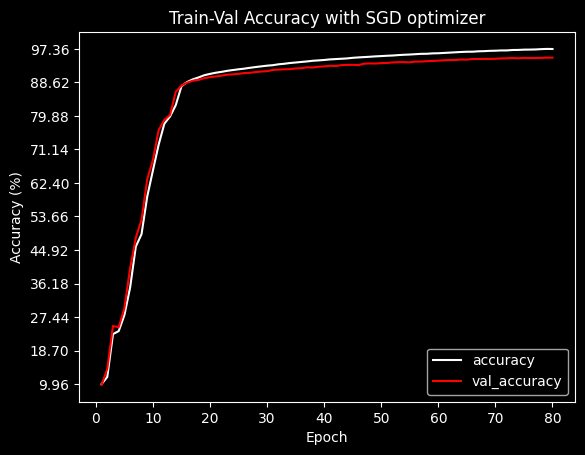

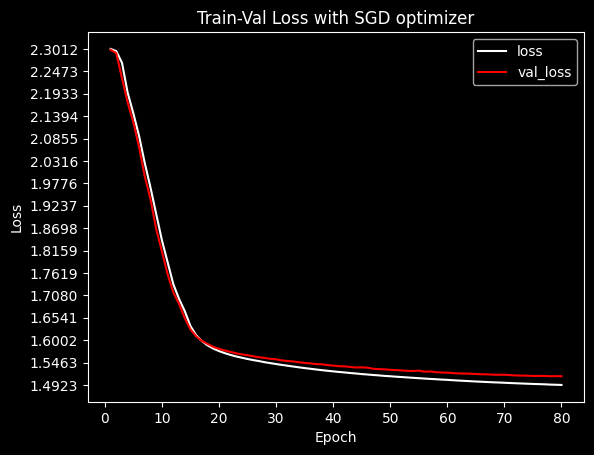


############################## Optimizer Adam training.. ##############################


------------------------------- TRAINING ON Class_Net1 -------------------------------
Learning rate: 0.001
Epoch 0 - loss: 1.6842 - accuracy: 79.7650 - val_loss: 1.6277 - val_accuracy: 83.8300
Epoch 10 - loss: 1.4894 - accuracy: 97.2775 - val_loss: 1.5043 - val_accuracy: 95.7500
Epoch 20 - loss: 1.4791 - accuracy: 98.2575 - val_loss: 1.4971 - val_accuracy: 96.4500
Epoch 30 - loss: 1.4755 - accuracy: 98.5925 - val_loss: 1.4970 - val_accuracy: 96.4300
Epoch 40 - loss: 1.4738 - accuracy: 98.7550 - val_loss: 1.4945 - val_accuracy: 96.6450
Epoch 50 - loss: 1.4722 - accuracy: 98.9100 - val_loss: 1.4942 - val_accuracy: 96.6850
Epoch 60 - loss: 1.4705 - accuracy: 99.0725 - val_loss: 1.4929 - val_accuracy: 96.8000
Epoch 70 - loss: 1.4705 - accuracy: 99.0750 - val_loss: 1.4921 - val_accuracy: 96.8950
Epoch 79 - loss: 1.4698 - accuracy: 99.1300 - val_loss: 1.4943 - val_accuracy: 96.6750

Model Class_Net1 T

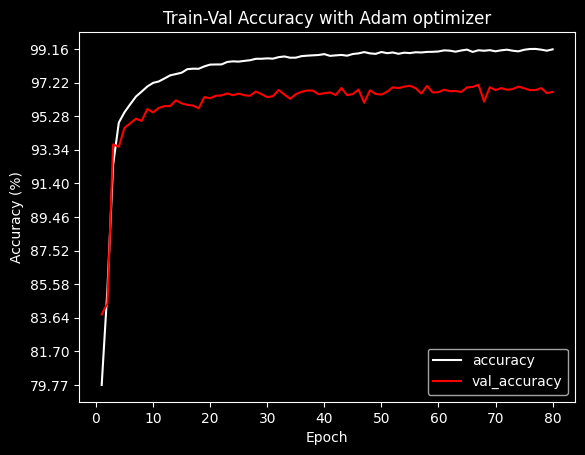

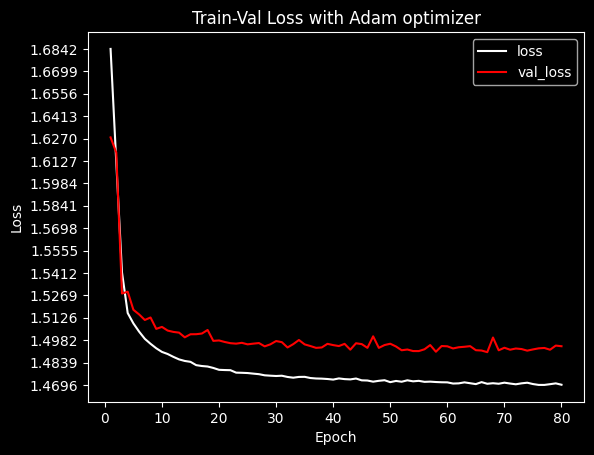


------------------------------- TRAINING ON Class_Net2 -------------------------------
Learning rate: 0.001
Epoch 0 - loss: 1.6242 - accuracy: 86.3075 - val_loss: 1.5642 - val_accuracy: 89.9750
Epoch 10 - loss: 1.4915 - accuracy: 97.0050 - val_loss: 1.5059 - val_accuracy: 95.5400
Epoch 20 - loss: 1.4822 - accuracy: 97.9300 - val_loss: 1.4977 - val_accuracy: 96.3500
Epoch 30 - loss: 1.4780 - accuracy: 98.3300 - val_loss: 1.4942 - val_accuracy: 96.6950
Epoch 40 - loss: 1.4767 - accuracy: 98.4400 - val_loss: 1.4938 - val_accuracy: 96.7150
Epoch 50 - loss: 1.4735 - accuracy: 98.7800 - val_loss: 1.4942 - val_accuracy: 96.7000
Epoch 60 - loss: 1.4726 - accuracy: 98.8725 - val_loss: 1.4975 - val_accuracy: 96.3700
Epoch 70 - loss: 1.4724 - accuracy: 98.8900 - val_loss: 1.4931 - val_accuracy: 96.8150
Epoch 79 - loss: 1.4720 - accuracy: 98.9375 - val_loss: 1.4922 - val_accuracy: 96.8950

Model Class_Net2 Test Loss: 1.4900857875823974
Model Class_Net2 Test Accuracy: %97.08





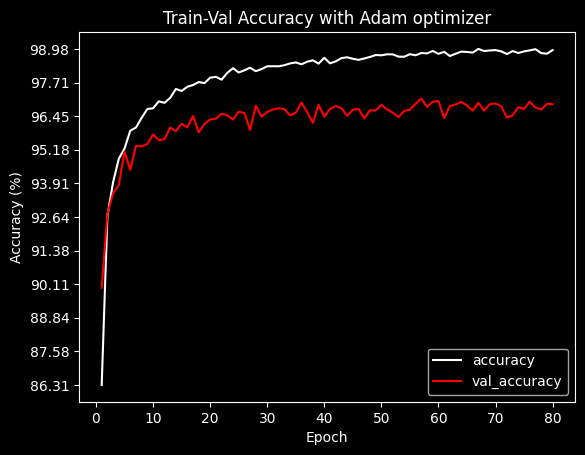

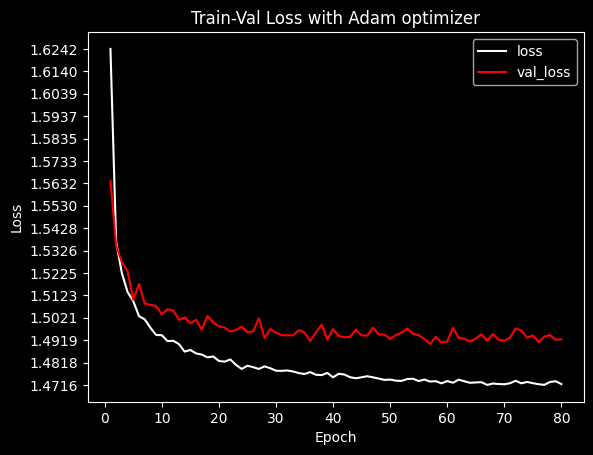


############################## Optimizer RMSprop training.. ##############################


------------------------------- TRAINING ON Class_Net1 -------------------------------
Learning rate: 0.01
Epoch 0 - loss: 2.3582 - accuracy: 10.2900 - val_loss: 2.3534 - val_accuracy: 10.7800
Epoch 10 - loss: 1.6279 - accuracy: 83.3200 - val_loss: 1.6281 - val_accuracy: 83.2950
Epoch 20 - loss: 1.6236 - accuracy: 83.7525 - val_loss: 1.6307 - val_accuracy: 83.0450
Epoch 30 - loss: 1.6247 - accuracy: 83.6350 - val_loss: 1.6380 - val_accuracy: 82.3200
Epoch 40 - loss: 1.6362 - accuracy: 82.4925 - val_loss: 1.6295 - val_accuracy: 83.1700
Epoch 50 - loss: 1.6179 - accuracy: 84.3200 - val_loss: 1.6284 - val_accuracy: 83.2750
Epoch 60 - loss: 1.6232 - accuracy: 83.7900 - val_loss: 1.6252 - val_accuracy: 83.5950
Epoch 70 - loss: 1.6216 - accuracy: 83.9575 - val_loss: 1.6295 - val_accuracy: 83.1650
Epoch 79 - loss: 1.6167 - accuracy: 84.4425 - val_loss: 1.6368 - val_accuracy: 82.4300

Model Class_Net1

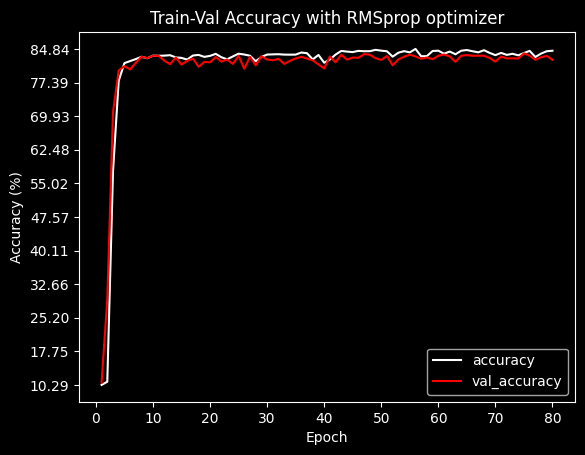

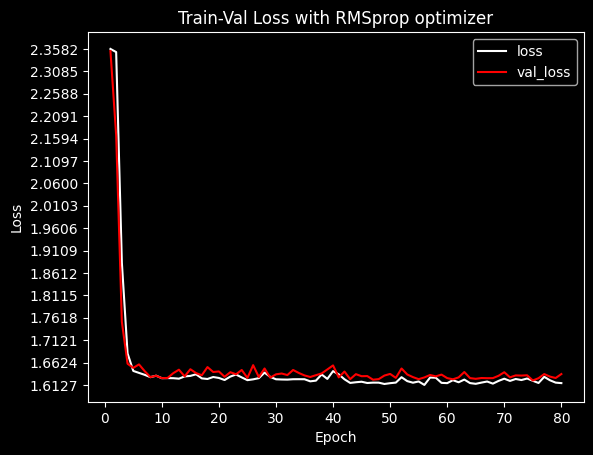


------------------------------- TRAINING ON Class_Net2 -------------------------------
Learning rate: 0.01
Epoch 0 - loss: 2.1040 - accuracy: 33.1525 - val_loss: 1.8225 - val_accuracy: 63.9100
Epoch 10 - loss: 1.6319 - accuracy: 82.9200 - val_loss: 1.6264 - val_accuracy: 83.4550
Epoch 20 - loss: 1.6313 - accuracy: 82.9200 - val_loss: 1.6213 - val_accuracy: 84.0450
Epoch 30 - loss: 1.6395 - accuracy: 82.1125 - val_loss: 1.6327 - val_accuracy: 82.8600
Epoch 40 - loss: 1.6493 - accuracy: 81.1250 - val_loss: 1.6866 - val_accuracy: 77.2650
Epoch 50 - loss: 1.6478 - accuracy: 81.2825 - val_loss: 1.6605 - val_accuracy: 80.1750
Epoch 60 - loss: 1.7078 - accuracy: 75.3050 - val_loss: 1.7149 - val_accuracy: 74.6300
Epoch 70 - loss: 1.6785 - accuracy: 78.2775 - val_loss: 1.7088 - val_accuracy: 75.2550
Epoch 79 - loss: 1.6748 - accuracy: 78.6025 - val_loss: 1.6551 - val_accuracy: 80.6150

Model Class_Net2 Test Loss: 1.6589114986419677
Model Class_Net2 Test Accuracy: %80.2





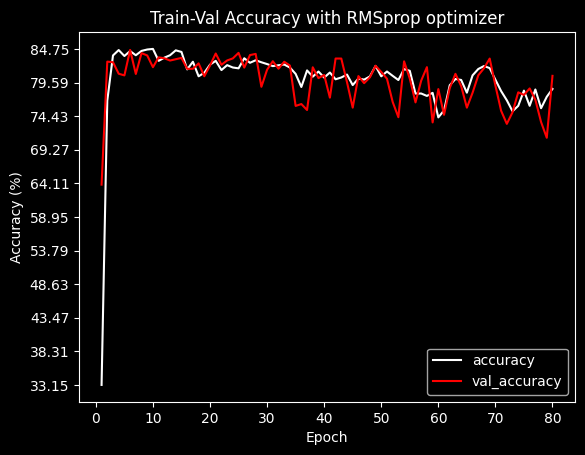

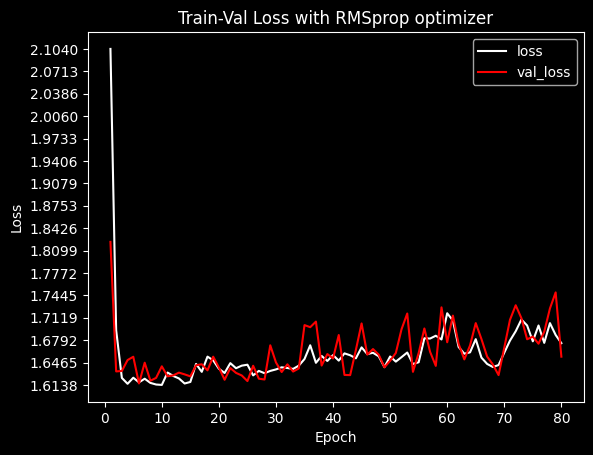


############################## Optimizer AdaDelta training.. ##############################


------------------------------- TRAINING ON Class_Net1 -------------------------------
Learning rate: 0.01
Epoch 0 - loss: 2.3011 - accuracy: 19.4425 - val_loss: 2.2993 - val_accuracy: 25.8800
Epoch 10 - loss: 1.7775 - accuracy: 72.6050 - val_loss: 1.7730 - val_accuracy: 72.5900
Epoch 20 - loss: 1.6769 - accuracy: 80.6900 - val_loss: 1.6815 - val_accuracy: 80.2200
Epoch 30 - loss: 1.6464 - accuracy: 82.8625 - val_loss: 1.6543 - val_accuracy: 81.8050
Epoch 40 - loss: 1.5833 - accuracy: 89.7500 - val_loss: 1.5876 - val_accuracy: 89.2650
Epoch 50 - loss: 1.5627 - accuracy: 91.2650 - val_loss: 1.5697 - val_accuracy: 90.4800
Epoch 60 - loss: 1.5533 - accuracy: 91.9425 - val_loss: 1.5617 - val_accuracy: 91.0500
Epoch 70 - loss: 1.5471 - accuracy: 92.4175 - val_loss: 1.5565 - val_accuracy: 91.2950
Epoch 79 - loss: 1.5428 - accuracy: 92.7750 - val_loss: 1.5532 - val_accuracy: 91.5450

Model Class_Net

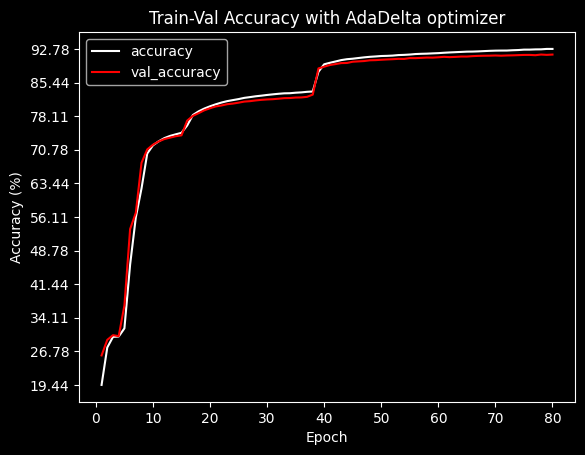

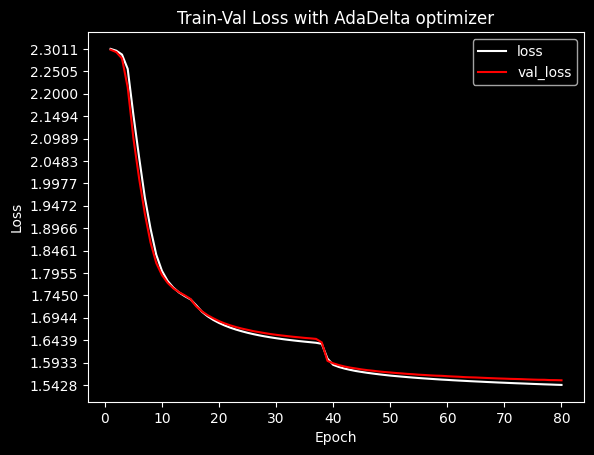


------------------------------- TRAINING ON Class_Net2 -------------------------------
Learning rate: 0.01
Epoch 0 - loss: 2.3008 - accuracy: 12.0450 - val_loss: 2.2992 - val_accuracy: 13.6900
Epoch 10 - loss: 1.8065 - accuracy: 71.9975 - val_loss: 1.7960 - val_accuracy: 72.2750
Epoch 20 - loss: 1.6641 - accuracy: 81.9775 - val_loss: 1.6638 - val_accuracy: 81.8150
Epoch 30 - loss: 1.5835 - accuracy: 89.8775 - val_loss: 1.5891 - val_accuracy: 89.0150
Epoch 40 - loss: 1.5542 - accuracy: 91.9400 - val_loss: 1.5633 - val_accuracy: 90.7600
Epoch 50 - loss: 1.5393 - accuracy: 93.0425 - val_loss: 1.5509 - val_accuracy: 91.7000
Epoch 60 - loss: 1.5287 - accuracy: 94.0225 - val_loss: 1.5422 - val_accuracy: 92.4700
Epoch 70 - loss: 1.5207 - accuracy: 94.6800 - val_loss: 1.5360 - val_accuracy: 93.0000
Epoch 79 - loss: 1.5149 - accuracy: 95.2050 - val_loss: 1.5311 - val_accuracy: 93.4400

Model Class_Net2 Test Loss: 1.5254649101257325
Model Class_Net2 Test Accuracy: %94.03





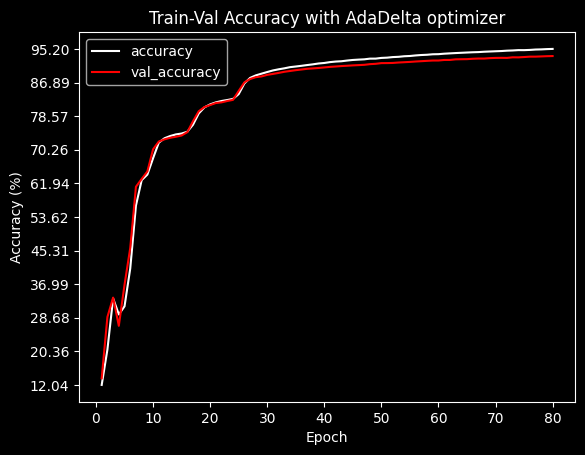

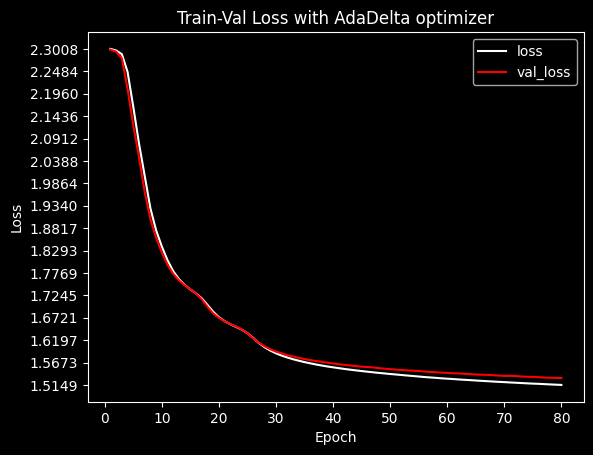


############################## Optimizer AdaGrad training.. ##############################


------------------------------- TRAINING ON Class_Net1 -------------------------------
Learning rate: 0.01
Epoch 0 - loss: 1.6784 - accuracy: 80.4500 - val_loss: 1.6451 - val_accuracy: 82.6050
Epoch 10 - loss: 1.6050 - accuracy: 86.0525 - val_loss: 1.6194 - val_accuracy: 84.2950
Epoch 20 - loss: 1.5985 - accuracy: 86.6125 - val_loss: 1.6146 - val_accuracy: 84.7600
Epoch 30 - loss: 1.5947 - accuracy: 86.9325 - val_loss: 1.6121 - val_accuracy: 84.9600
Epoch 40 - loss: 1.5918 - accuracy: 87.2175 - val_loss: 1.6108 - val_accuracy: 85.1450
Epoch 50 - loss: 1.5896 - accuracy: 87.4325 - val_loss: 1.6094 - val_accuracy: 85.2050
Epoch 60 - loss: 1.5878 - accuracy: 87.6050 - val_loss: 1.6084 - val_accuracy: 85.3050
Epoch 70 - loss: 1.5862 - accuracy: 87.7200 - val_loss: 1.6077 - val_accuracy: 85.3750
Epoch 79 - loss: 1.5851 - accuracy: 87.8525 - val_loss: 1.6072 - val_accuracy: 85.4150

Model Class_Net1

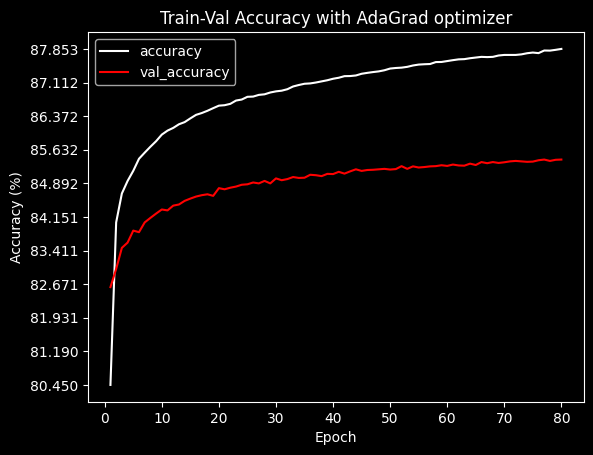

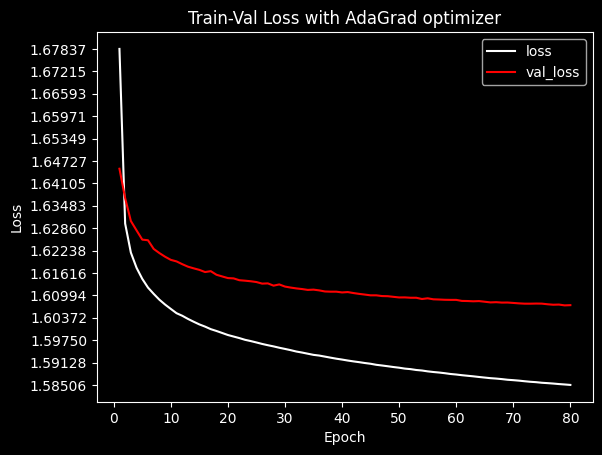


------------------------------- TRAINING ON Class_Net2 -------------------------------
Learning rate: 0.01
Epoch 0 - loss: 1.6080 - accuracy: 87.5850 - val_loss: 1.5580 - val_accuracy: 91.0550
Epoch 10 - loss: 1.4916 - accuracy: 97.1875 - val_loss: 1.5081 - val_accuracy: 95.4850
Epoch 20 - loss: 1.4817 - accuracy: 98.0750 - val_loss: 1.5024 - val_accuracy: 95.9500
Epoch 30 - loss: 1.4776 - accuracy: 98.4400 - val_loss: 1.4995 - val_accuracy: 96.2950
Epoch 40 - loss: 1.4757 - accuracy: 98.6000 - val_loss: 1.4982 - val_accuracy: 96.3450
Epoch 50 - loss: 1.4745 - accuracy: 98.6975 - val_loss: 1.4974 - val_accuracy: 96.4000
Epoch 60 - loss: 1.4737 - accuracy: 98.7850 - val_loss: 1.4971 - val_accuracy: 96.5050
Epoch 70 - loss: 1.4731 - accuracy: 98.8225 - val_loss: 1.4966 - val_accuracy: 96.5450
Epoch 79 - loss: 1.4728 - accuracy: 98.8475 - val_loss: 1.4960 - val_accuracy: 96.5700

Model Class_Net2 Test Loss: 1.4933606748580932
Model Class_Net2 Test Accuracy: %96.78





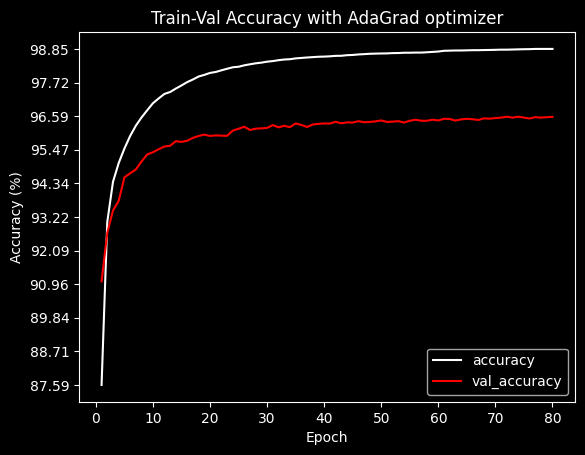

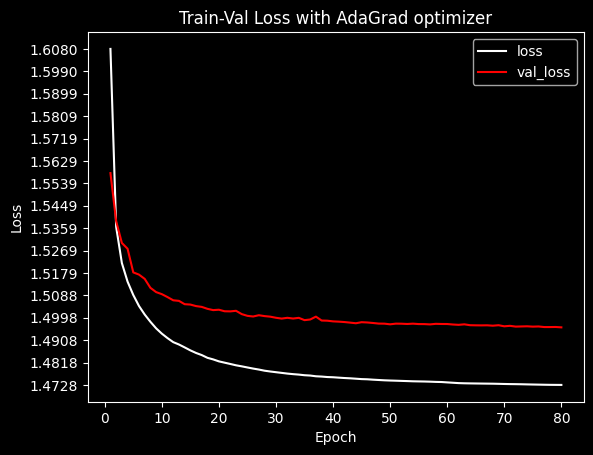

In [ ]:
for opt_name, opt in optimizers.items():
    print(f"############################## Optimizer {opt_name} training.. ##############################\n\n")


    for model in models:
        print(f"------------------------------- TRAINING ON {model.__class__.__name__} -------------------------------")
        if opt_name == "Adam":
            learning_rate = 0.001
        else:
            learning_rate = 0.01
        print(f"Learning rate: {learning_rate}")        
        optimizer = opt(model.parameters(), learning_rate)

        loss_list, train_acc_list, val_loss_list, val_acc_list = train_classification(epoch, train_data, val_data, optimizer, model, loss_func)

        test(model)

        best_acc = max([list(a) for a in zip([max(train_acc_list)], [max(val_acc_list)])][0])
        worst_acc = min([list(a) for a in (zip([min(train_acc_list)], [min(train_acc_list)]))][0])
        best_loss = min([list(a) for a in zip([min(loss_list)], [min(loss_list)])][0])
        worst_loss = max([list(a) for a in (zip([max(loss_list)], [max(val_loss_list)]))][0])

        print("\n")
      
        plt.cla()
        plt.title(f"Train-Val Accuracy with {opt_name} optimizer")
        plt.plot(range(1, epoch+1), train_acc_list, color='w', label='accuracy')
        plt.plot(range(1, epoch+1),val_acc_list, color='r', label='val_accuracy')
        plt.xticks(np.arange(0, epoch+1, 10))
        plt.yticks(np.arange(worst_acc, best_acc+0.0001, (best_acc-worst_acc) / 10.0))
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.pause(0.1) 
        plt.show()

        print("")

        plt.cla()
        plt.title(f"Train-Val Loss with {opt_name} optimizer")
        plt.plot(range(1, epoch+1), loss_list, color='w', label='loss')
        plt.plot(range(1, epoch+1), val_loss_list, color='r', label='val_loss')
        plt.xticks(np.arange(0, epoch+1, 10))
        plt.yticks(np.arange(best_loss, worst_loss+0.0001, (worst_loss-best_loss) / 15.0))
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.pause(0.1) 
        plt.show()
        
        print("")
       


    classnet1 = Class_Net1().to(device=device)
    classnet2 = Class_Net2().to(device=device)
    models = [classnet1, classnet2]

    



# RESULTS - CLASSIFICATION - GENERAL

## Network-1 - Less Complex Net

---



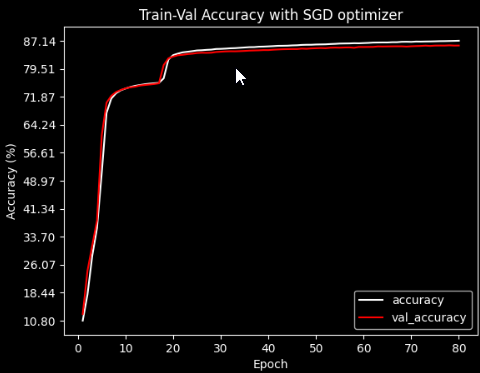
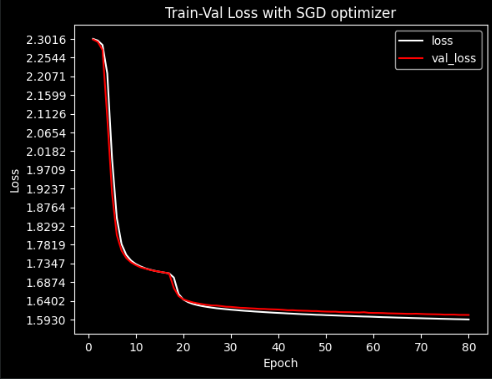

Here we can see that train and validation values are not converging properly

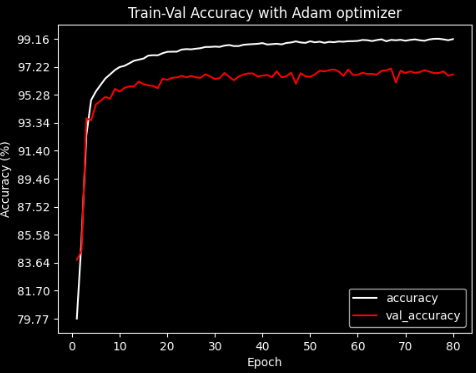
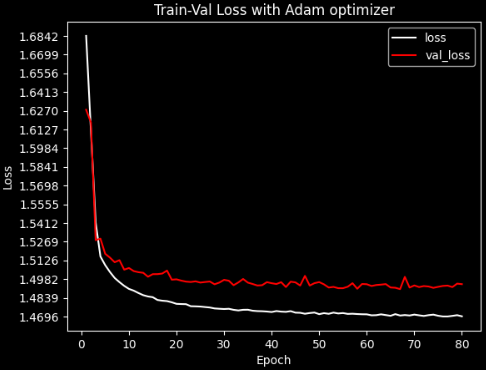

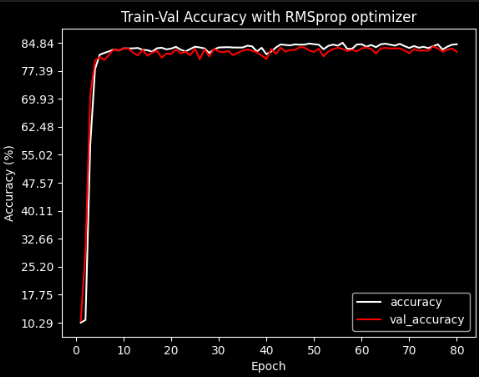
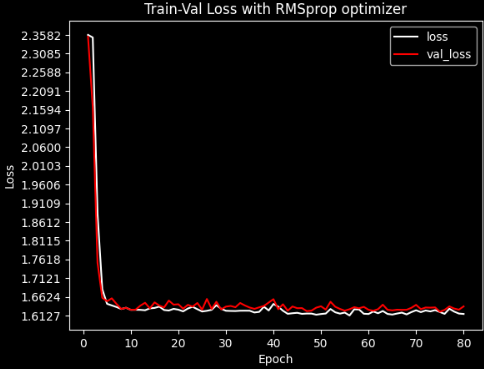

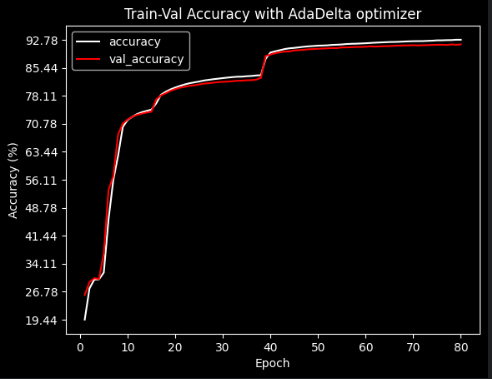
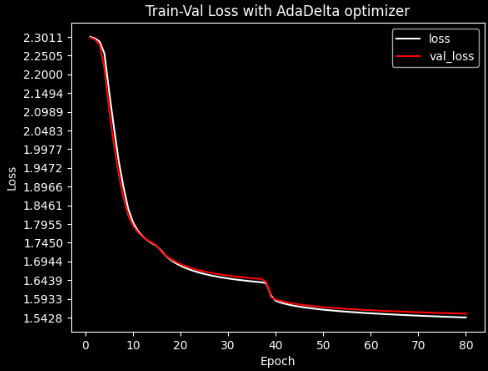

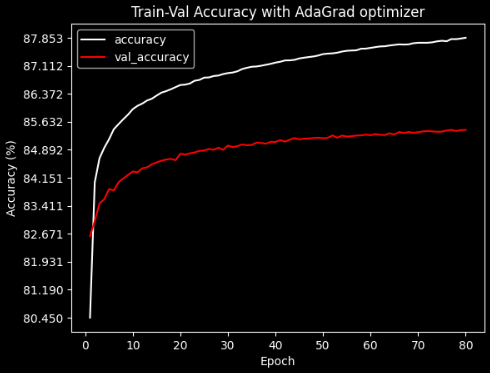
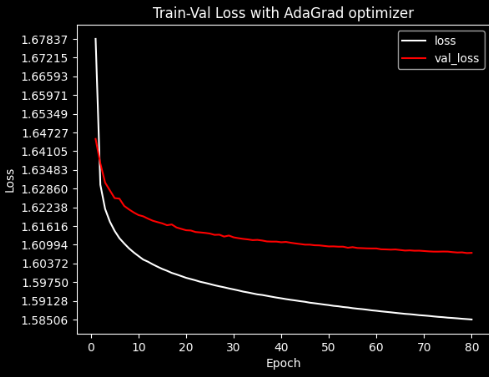

Except for Adam optimizer, we see that the accuracy values of the optimizers cannot exceed 85%-87% as seen in the results. For the Adam optimization, we see that accuracy is close to memorization. Therefore, the interpretation we can make for sure is that this network is insufficient for this dataset. However, if we still need to make a choice, it would be most logical to use Adam optimizer at low epoch values (around 20-30).

## Network-2 More Complex Net

---

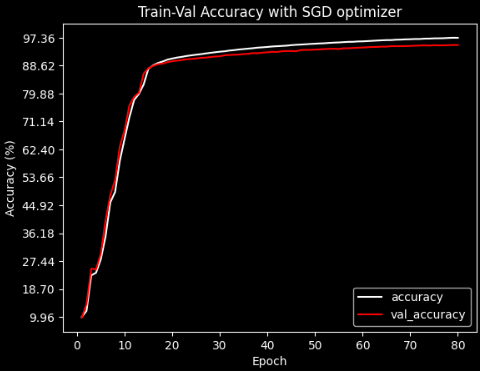
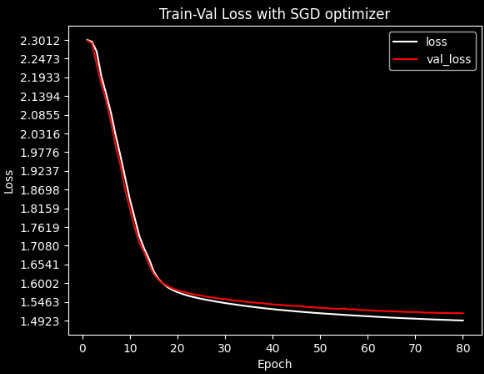

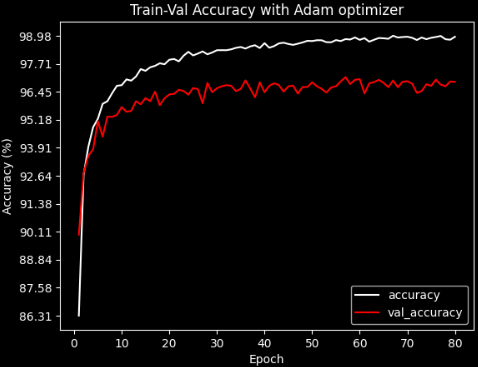
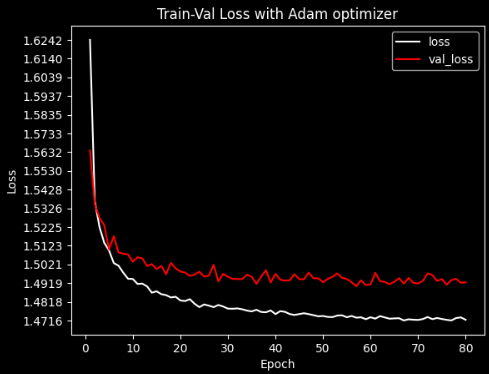

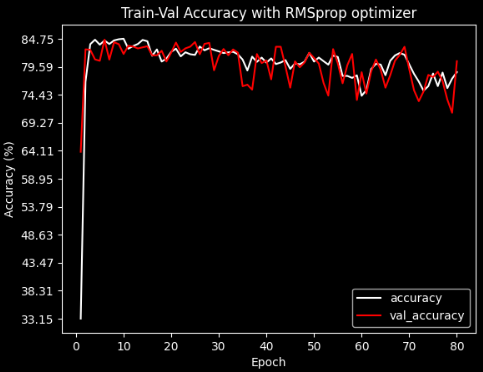
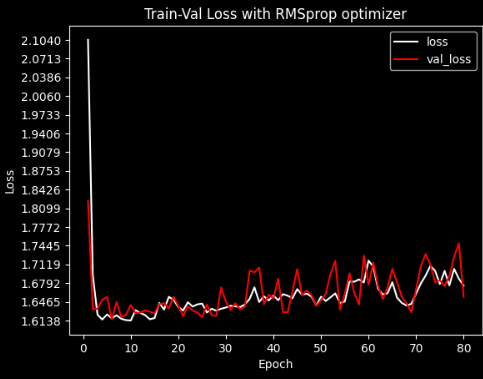

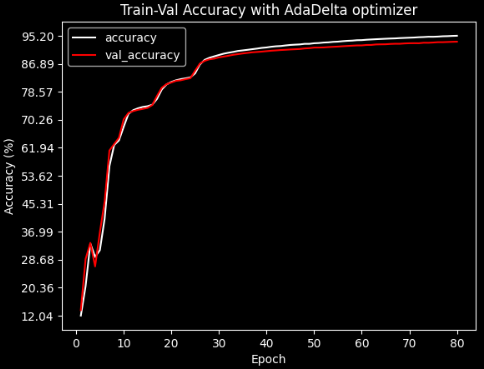
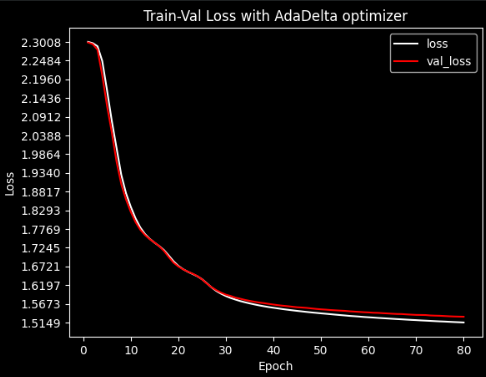

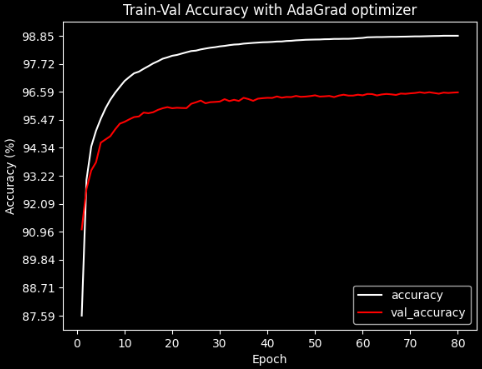
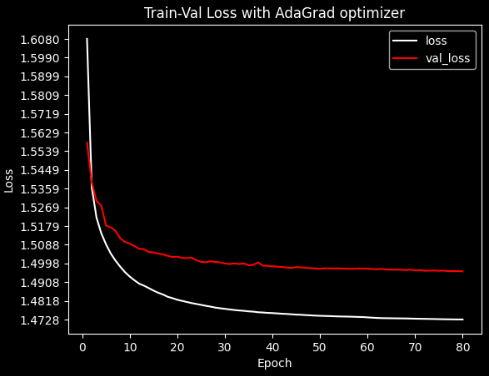

When we look at the accuracy order in the complex network, from high to low:
Adam, AdaGrad, SGD, AdaDelta, RMSprop are displayed.

The definitive comment we will take from here is that the RMSprop optimizer should definitely not be used in this case.

On the other hand, we see that Adam was the one who reached the lowest loss values at the earliest, but the validation and training values did not combine.
When we look at the merger, we see that there are SGD and AdaDelta.

In this part, it gets a little more difficult to understand which optimizer we should choose except RMSprop.
If we want to get the highest accuracy value, Adam seems to be the most logical option, but we also see that the loss values of all optimizers, including Adam, are around 1.5.
In order to reduce this value, we can make the network more complex or use different activation functions. (Can be sigmoid or ReLU.)


# To Sum Up,
While both RMSprop and Adam give good results for regression, we see that RMSprop does not work well for MNIST Classification Dataset, and Adam gives high accuracy values. However, we should not forget that the loss values are not very low. We also need to avoid networks with little complexity for both Regression and Classification.
